# Processing
- vital data -> 20s segment => peak detection & preprocessing & lowess filtering

In [4]:
import os, sys
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pyvital2 import arr


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)


# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T


# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)


### input 설정
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 300 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수
SRATE = 100


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'vital_data/PPG_100Hz_ECG_100Hz_pacu_5min'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


error_list = []
SRATE, f_num = 100, 1000
for f_vital in f_vital_list[1000:2000]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
    
    
    ppg_cache = "../../cranberry2/Preprocessing/cache/peaks/PPG_100Hz_pacu_5min_seg/" + f_vital
    ecg_cache = "../../cranberry2/Preprocessing/cache/peaks/ECG_100Hz_pacu_5min_seg/" + f_vital    
    
 
    # 20초 단위로 끊기
    for i in range(n_aug):
        print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg = df_vital_input['PPG'].tolist()
        seg_ecg = df_vital_input['ECG'].tolist()
        
        
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            print('too much missing data')
            continue
    
    
    
        ### 2. Noise 처리 ###
        # peak detection
        if os.path.exists(ppg_cache+'_{}'.format(i+1)):
            _, ppg_peak = pickle.load(open(ppg_cache+'_{}'.format(i+1), 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_{}'.format(i+1), 'rb'))
            print('...loaded peak...', end='')
            

        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
            
            except Exception as e:
                print('error of', e)
                error_list.append(f_vital)
                df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-3, -3])
                continue
                
            
            if len(ppg_peak)==0:
                print('no peak')
                
                
            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_{}'.format(i+1), 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_{}'.format(i+1), 'wb'))
            print('...saved peak...', end='')
            
        
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak
        
        
        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            print('too less peaks')
            continue

            
        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True
                
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)        
        print('preprocessing done...', end='')
        
        
        
        # 전처리 성공한 case에 대해 lowess filter 적용
        if bool_pass:
            print('passed...lowess filtering...', end='')
            save_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess6/pacu_'+f_vital
            if os.path.exists(save_path+'_{}'.format(i+1)):
                print('already exists')
                continue
                
                
            ppg_inp = pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            ecg_inp = pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            
            
            ppg_input = ppg_inp - smooth(ppg_inp)
            ecg_input = ecg_inp - smooth(ecg_inp)
                                        
            
            pickle.dump([ppg_input, ecg_input],  open(save_path+'_{}'.format(i+1), 'wb'))
            print('done')
    
        else:
            print('failed')
            

    if f_num%100 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 10075')
        pickle.dump(df_preprocess, open('../DL_model/cache/preprocess6/df_preprocess_pacu_1000-2000', 'wb'))

        
print('dumping cache of d_preprocess -', f_num, '/ 10075')
pickle.dump(df_preprocess, open('../DL_model/cache/preprocess6/df_preprocess_pacu_1000-2000', 'wb'))


###Input 1001 / 10075: 6.0,1847,PACU1_3_190826_003738.vital###
  segment 1...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 2...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 3...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 4...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 5...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 6...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 7...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 8...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 9...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 10...loaded peak...preprocessing done...passed...lowess filtering...already exists
  segment 11...l

  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...passed...lowess filt

  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...too less peaks
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...too less peaks
  segment 22...saved peak...too less peaks
  segment 23...saved peak...too less peaks
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...too less peaks
  segment 26...saved peak...too less peaks
  segment 27...saved peak...too less peaks
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...too less peaks
  segment 35...saved peak...too less peaks
  segment 36...saved peak...too less peaks
  segment 

  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...s

  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...too less peaks
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done..

  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done..

  segment 50...saved peak...preprocessing done...passed...lowess filtering...done
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 1019 / 10075: 3.0,782,PACU1_2_190601_014236.vital###
  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 

  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done..

  segment 35...saved peak...preprocessing done...passed...lowess filtering...done
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...passed...lo

  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...s

  segment 35...saved peak...preprocessing done...passed...lowess filtering...done
  segment 36...saved peak...preprocessing done...passed...lowess filtering...done
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocess

  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 1038 / 10075: 6.0,8513,PACU1_9_200624_114423.vital###
  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  s

  segment 32...saved peak...preprocessing done...passed...lowess filtering...done
  segment 33...saved peak...preprocessing done...passed...lowess filtering...done
  segment 34...saved peak...preprocessing done...passed...lowess filtering...done
  segment 35...saved peak...preprocessing done...passed...lowess filtering...done
  segment 36...saved peak...preprocessing done...passed...lowess filtering...done
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...s

KeyboardInterrupt: 

## pacu (20/12/28) ***

In [49]:
import os, sys
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pyvital2 import arr


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)


# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T


# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)


### input 설정
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 300 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수
SRATE = 100


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'vital_data/PPG_100Hz_ECG_100Hz_pacu_5min'
ecg_path = preprocess_path + 'vital_data/ECG_250Hz_pacu_5min'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


error_list = []
SRATE, f_num = 100, 100
initial = f_num
interval = 300
for f_vital in f_vital_list[initial:initial+interval]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    df_ecg = pickle.load(open(ecg_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
    
    
    ppg_cache = "../../cranberry2/Preprocessing/cache/peaks/PPG_100Hz_pacu_5min_seg/" + f_vital
    ecg_cache = "../../cranberry2/Preprocessing/cache/peaks/ECG_100Hz_pacu_5min_seg/" + f_vital    
    ecg_cache2 = "../../cranberry2/Preprocessing/cache/peaks/ECG_250Hz_pacu_5min_seg/" + f_vital
 
    # 20초 단위로 끊기
    for i in range(n_aug):
        print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg = df_vital_input['PPG'].tolist()
        seg_ecg = df_vital_input['ECG'].tolist()
        
        
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            print('too much missing data')
            continue
    
    
    
        ### 2. Noise 처리 ###
        # peak detection
        if os.path.exists(ppg_cache+'_{}'.format(i+1)):
            _, ppg_peak = pickle.load(open(ppg_cache+'_{}'.format(i+1), 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_{}'.format(i+1), 'rb'))
            print('...loaded peak...', end='')
            

        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                
            
            except Exception as e:
                print('error of', e)
                error_list.append(f_vital)
                df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-3, -3])
                continue
                
            
            if len(ppg_peak)==0:
                print('no peak')
                
                
            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_{}'.format(i+1), 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_{}'.format(i+1), 'wb'))
            print('...saved peak...', end='')
            
        
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak
        
        
        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            print('too less peaks')
            continue

            
        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True
                
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)        
        print('preprocessing done...', end='')
        
        
        
        # 전처리 성공한 case에 대해 lowess filter 적용
        if bool_pass:
            print('passed...lowess filtering...', end='')
            save_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess6/pacu_'+f_vital
            if os.path.exists(save_path+'_{}'.format(i+1)):
                print('already exists')
                continue
                
                
            start_idx = i*OVERLAP*250
            end_idx = (i*OVERLAP + LEN_INPUT)*250
            seg_ecg2 = df_ecg.loc[start_idx:end_idx-1]
            ecg_inp = seg_ecg2[['ECG']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            
            try:
                ecg_peak2 = arr.detect_qrs(ecg_inp, 250)
                
            except Exception as e:
                print('error on 250Hz peak:', e)
                
            else:
                pickle.dump(ecg_peak2, open(ecg_cache2+'_{}'.format(i+1),'wb'))
            
            
            ppg_inp = pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            #ppg_inp = signal.resample(ppg_inp, 250*LEN_INPUT)
            
            
            ppg_input = ppg_inp - smooth(ppg_inp)
            ecg_input = ecg_inp - smooth(ecg_inp)
                                        
            
            pickle.dump([ppg_input, ecg_input],  open(save_path+'_{}'.format(i+1), 'wb'))
            print('done')
            
    
        else:
            print('failed')
        

    if f_num%100 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 10075')
        pickle.dump(df_preprocess, open('../DL_model/cache/preprocess6/df_preprocess_pacu_{}-{}'.format(initial, initial+interval), 'wb'))

        
print('dumping cache of d_preprocess -', f_num, '/ 10075')
pickle.dump(df_preprocess, open('../DL_model/cache/preprocess6/df_preprocess_pacu_{}-{}'.format(initial, initial+interval), 'wb'))


###Input 101 / 10075: 6.0,7090,PACU1_5_200818_182106.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...too less peaks
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done

  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak

  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...s

  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...passed...lowess filtering...done
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 114 / 10075: 3.0,7353,PACU1_3_200911_121317.vital###
  segment 1...saved peak...too less peaks
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved p

  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 118 / 10075: 4.0,5624,PACU1_1_200604_014017.vital###
  segment 1too much missing data
  segment 2too much missing data
  segment 3too much missing data
  segment 4too much missing data
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...failed
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment

  segment 19...saved peak...preprocessing done...passed...lowess filtering...done
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...passed...lowess filtering...done
  segment 28...saved peak...preprocessing done...passed...lowess filtering...done
  segment 29...saved peak...preprocessing done...passed...lowess filtering...done
  segment 30...saved peak...preprocessing done...passed...lowess filtering...done
  segment 31...saved peak...preprocessing done...passed...lowess filtering...done
  segment 32...saved peak...preprocessing done...passed...lowess filtering...done
  segment 33...saved peak...prepro

  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done..

  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 131 / 10075: 2.0,10051,PACU1_4_200911_113855.vital###
  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...prep

  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 135 / 10075: 6.0,4801,PACU1_8_200325_180118.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
 

  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...passed...lowess filtering...done
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preprocessing done...passed...lowess filtering...done
  segment 18...saved peak...preprocessing done...passed...lowess filtering...done
  segment 19...saved peak...preprocessing done...passed...lowess filtering...done
  segment 20...saved peak...preprocessing done...passed...lowess filtering...done
  segment 21...saved peak...preprocessing done...passed...lowess filtering...done
  segment 22...saved peak...preprocessing done...passed...lowess filtering...done
  segment 23...saved peak...preprocessing done...passed...lowess filtering...done
  segment 24...saved peak...preprocessing done...passed...lowess filtering...done
  segment 25...s

  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 144 / 10075: 3.0,2291,PACU1_2_190910_100401.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...failed
  s

  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 146 / 10075: 4.0,79,PACU1_1_190419_113101.vital###
  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...failed
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...preprocessing done...passed...lowess filt

  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...passed...lowess filterin

  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...passed...lowess filtering.

  segment 25too much missing data
  segment 26too much missing data
  segment 27too much missing data
  segment 28too much missing data
  segment 29too much missing data
  segment 30too much missing data
  segment 31too much missing data
  segment 32too much missing data
  segment 33too much missing data
  segment 34too much missing data
  segment 35too much missing data
  segment 36too much missing data
  segment 37too much missing data
  segment 38too much missing data
  segment 39too much missing data
  segment 40too much missing data
  segment 41too much missing data
  segment 42too much missing data
  segment 43too much missing data
  segment 44too much missing data
  segment 45too much missing data
  segment 46too much missing data
  segment 47too much missing data
  segment 48too much missing data
  segment 49too much missing data
  segment 50too much missing data
  segment 51too much missing data
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done


  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed


  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...too less peaks
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  seg

  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...too less peaks
  segment 51...saved peak...too less peaks
  segment 52...saved peak...too less peaks
  segment 53...saved peak...too less peaks
  segment 54...saved peak...too less peaks
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 168 / 10075: 7.0,5744,PACU1_2_200609_124225.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...failed
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  se

  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done..

  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 175 / 10075: 5.0,8247,PACU1_8_201027_100019.vital###
  segment 1too much missing data
  segment 2too much missing data
  segment 3too much missing data

  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 179 / 10075: 3.0,8815,PACU1_1_190717_084957.vital###
  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing d

  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 181 / 10075: 4.0,3386,PACU1_4_200131_084902.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preproces

  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 185 / 10075: 9.0,174,PACU1_1_190430_140732.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...failed
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...too less peaks
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment 12...sa

  segment 22...saved peak...preprocessing done...passed...lowess filtering...done
  segment 23...saved peak...preprocessing done...passed...lowess filtering...done
  segment 24...saved peak...preprocessing done...passed...lowess filtering...done
  segment 25...saved peak...preprocessing done...passed...lowess filtering...done
  segment 26...saved peak...preprocessing done...passed...lowess filtering...done
  segment 27...saved peak...preprocessing done...passed...lowess filtering...done
  segment 28...saved peak...preprocessing done...passed...lowess filtering...done
  segment 29...saved peak...preprocessing done...passed...lowess filtering...done
  segment 30...saved peak...preprocessing done...passed...lowess filtering...done
  segment 31...saved peak...preprocessing done...passed...lowess filtering...done
  segment 32...saved peak...preprocessing done...passed...lowess filtering...done
  segment 33...saved peak...preprocessing done...passed...lowess filtering...done
  segment 34...s

  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...fai

  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 194 / 10075: 4.0,5231,PACU1_9_200519_095216.vital###
  segment 1too much missing data
  segment 2too much missing data
  segment 3too much missing data
  segment 4too much missing data
  segment 5too much missing data
  segment 6too much missing data
  segment 7too much missing data
  segment 8too much missing data
  segment 9too much missing data
  segment 10too much missing data
  segment 11too much missing data
  segment 12too much missing data
  segment 13too much missing data
  segment 14too much missing data
  segment 15too much missing data
  segment 16too much mi

  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...too less peaks
  segment 28...saved peak...too less peaks
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...too less peaks
  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...too less peaks
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...too less peaks
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
 

  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak

  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...passed...lowess filtering...done
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...s

  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 207 / 10075: 6.0,106,PACU1_4_190424_232403.vital###
  segment 1...saved peak...too less peaks
  segment 2...saved peak...too less peaks
  segment 3...saved peak...too less peaks
  segment 4...saved peak...too less peaks
  segment 5...saved peak...too less peaks
  segment 6...saved peak...too less peaks
  segment 7...saved peak...too less peaks
  segment 8...saved peak...too less peaks
  segment 9...saved peak...too less peaks
  segment 10...saved peak...too less peaks
  segment 11...saved peak...too less peaks
  segment 12...saved peak...too less peaks
  segment 13...saved peak...too less peaks
  segment 14...saved peak...too less peaks
  segment 15...sav

  segment 26...saved peak...too less peaks
  segment 27...saved peak...too less peaks
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...too less peaks
  segment 30...saved peak...too less peaks
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...too less peaks
  segment 38...saved peak...too less peaks
  segment 39...saved peak...too less peaks
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...too less peaks
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessin

  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed


  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...passed...lowess filtering...done
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preprocessing done...passed...lowess filtering...done
  segment 18...saved peak...preprocessing done...passed...lowess filtering...done
  segment 19...saved peak...preprocessing done...passed...lowess filtering...done
  segment 20...saved peak...preprocessing done...passed...lowess filtering...done
  segment 21...saved peak...preprocessing done...passed...lowess filtering...done
  segment 22...saved peak...preprocessing done...passed...lowess filtering...done
  segment 23...saved peak...preprocessing done...passed...lowess filtering...done
  segment 24...saved peak...preprocessing 

  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...passed...lowess filtering...done
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preprocessing done...passed...lowess filtering...done
  segment 18...saved peak...preprocessing done...passed...lowess filtering...done
  segment 19...saved peak...preprocessing done...passed...lowess filtering...done
  segment 20...saved peak...preprocessing done...passed...lowess filtering...done
  segment 21...saved peak...preprocessing done...passed...lowess filtering...done
  segment 22...saved peak...preprocessing done...passed...lowess filtering...done
  segment 23...saved peak...preprocessing done...passed...lowess filtering...done
  segment 24...s

  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...passed...lowess filtering...done
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segme

  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...passed...lowess filtering...done
  segment 24...saved peak...preprocessing done...passed...lowess filtering...done
  segment 25...saved peak...preprocessing done...passed...lowess filtering...done
  segment 26...saved peak...preprocessing done...passed...lowess filtering...done
  segment 27...saved peak...preprocessing done...passed...lowess filtering...done
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  se

  segment 28...saved peak...preprocessing done...passed...lowess filtering...done
  segment 29...saved peak...preprocessing done...passed...lowess filtering...done
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...passed...lowess filtering...done
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...pr

  segment 32...saved peak...preprocessing done...passed...lowess filtering...done
  segment 33...saved peak...preprocessing done...passed...lowess filtering...done
  segment 34...saved peak...preprocessing done...passed...lowess filtering...done
  segment 35...saved peak...preprocessing done...passed...lowess filtering...done
  segment 36...saved peak...preprocessing done...passed...lowess filtering...done
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...s

  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 240 / 10075: 6.0,9614,PACU1_8_200331_095710.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preproces

  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...passed...lowess filtering...done
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...s

  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...passed...lowess filtering...done
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done..

  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preprocessing done...passed...lowess filtering...done
  segment 18...saved peak...preprocessing done...passed...lowess filtering...done
  segment 19...saved peak...preprocessing done...passed...lowess filtering...done
  segment 20...saved peak...preprocessing done...passed...lowess filtering...done
  segment 21...saved peak...preprocessing done...passed...lowess filtering...done
  segment 22...saved peak...preprocessing done...passed...lowess filtering...done
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segmen

  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...passed...lowess filtering...done
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...s

  segment 24...saved peak...preprocessing done...passed...lowess filtering...done
  segment 25...saved peak...preprocessing done...passed...lowess filtering...done
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...passed...lowess filtering...done
  segment 33...saved peak...preprocessing done...passed...lowess filtering...done
  segment 34...saved peak...preprocessing done...passed...lowess filtering...done
  segment 35too much missing data
  segment 36too much missing data
  segment 37too much missing data
  segment 38too much missing data
  segment 39too much missing data
  segment 40too much missing data
  segment 41too much missing data
  segment 42too 

  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 260 / 10075: 6.0,3270,PACU1_5_200123_115000.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...failed
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...fa

  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...passed...lowess filtering...done
  segment 21...saved peak...preprocessing done...passed...lowess filtering...done
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved pea

  segment 19...saved peak...preprocessing done...passed...lowess filtering...done
  segment 20...saved peak...preprocessing done...passed...lowess filtering...done
  segment 21...saved peak...preprocessing done...passed...lowess filtering...done
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...passed...lowess filtering...done
  segment 34...saved peak...preprocessing done...passed.

  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done..

  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...too less peaks
  segment 19...saved peak...too less peaks
  segment 20...saved peak...too less peaks
  segment 21...saved peak...too less peaks
  segment 22...saved peak...too less peaks
  segment 23...saved peak...too less peaks
  segment 24...saved peak...too less peaks
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak..

  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...passed...lowess filtering...done
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...passed...lowess filtering...d

  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...too less peaks
  segment 19...saved peak...preprocessing done...failed
  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...too less peaks
  segment 25...saved peak...too less peaks
  segment 26...saved peak...too less peaks
  segment 27...saved peak...too less peaks
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
 

  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved pea

  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...too less peaks
  segment 38...saved peak...too less peaks
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...too less peaks
  segment 47...saved peak...too less peaks
  segment 48...saved peak...too less peaks
  segment 49...saved peak...too less peaks
  segment 50...saved peak...too less peaks
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak..

  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...failed
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...too less peaks
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...too less peaks
  segment 17...saved peak...too less peaks
  segment 18...saved peak...preprocessing done...failed
  segment 19...saved peak...preprocessin

  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 300 / 10075: 5.0,1958,PACU1_10_190829_143557.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...save

  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preprocess

  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...passed...lowess filtering...done
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preprocessing done...passed...lowess filtering...done
  segment 18...saved

  segment 49...saved peak...too less peaks
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...too less peaks
  segment 57...saved peak...too less peaks
###Input 309 / 10075: 4.0,5850,PACU1_9_200612_153815.vital###
  segment 1too much missing data
  segment 2too much missing data
  segment 3too much missing data
  segment 4too much missing data
  segment 5too much missing data
  segment 6too much missing data
  segment 7too much missing data
  segment 8too much missing data
  segment 9too much missing data
  segment 10too much missing data
  segment 11too much missing data
  segment 12too much missing data
  segment 13too much missing data
  segment 14too much missing data
  segm

  segment 22...saved peak...preprocessing done...passed...lowess filtering...done
  segment 23...saved peak...preprocessing done...passed...lowess filtering...done
  segment 24...saved peak...preprocessing done...passed...lowess filtering...done
  segment 25...saved peak...preprocessing done...passed...lowess filtering...done
  segment 26...saved peak...preprocessing done...passed...lowess filtering...done
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...pr

  segment 21...saved peak...too less peaks
  segment 22...saved peak...too less peaks
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...too less peaks
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...too less peaks
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...too less peaks
  segment 32...saved peak...too less peaks
  segment 33...saved peak...too less peaks
  segment 34...saved peak...too less peaks
  segment 35...saved peak...too less peaks
  segment 36...saved peak...too less peaks
  segment 37...saved peak...too less peaks
  segment 38...saved peak...too less peaks
  segment 39...saved peak...too less peaks
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...

  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...passed...lowess filtering...done
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...s

  segment 31...saved peak...preprocessing done...passed...lowess filtering...done
  segment 32...saved peak...preprocessing done...passed...lowess filtering...done
  segment 33...saved peak...preprocessing done...passed...lowess filtering...done
  segment 34...saved peak...preprocessing done...passed...lowess filtering...done
  segment 35...saved peak...preprocessing done...passed...lowess filtering...done
  segment 36...saved peak...preprocessing done...passed...lowess filtering...done
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...s

  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done..

  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...saved peak...preprocessing done...passed...lowess filtering...done
  segment 42...saved peak...preprocessing done...passed...lowess filtering...done
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed.

  segment 46...saved peak...too less peaks
  segment 47...saved peak...too less peaks
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...preprocessing done...failed
###Input 334 / 10075: 5.0,8074,PACU1_5_201016_183640.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...passed...lowess filterin

  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...preprocessing done...failed
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...failed
  segment 7...saved peak...preprocessing done...failed
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...failed
  segment 13...saved peak...preprocessing done...failed
  segment 14...saved peak...preprocessing done...passed...lowess filtering...done
  segment 15...saved peak...preprocessing done...passed...lowess filtering...done
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preproc

  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 338 / 10075: 6.0,2237,PACU1_1_190906_171533.vital###
  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing

  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...passed...lowess filtering...done
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...failed
###Input 342 / 10075: 8.0,9859,PACU1_9_200630_141540.vital###
  segment 1...saved peak...too less peaks
  segment 2...saved 

  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...passed...lowess filtering...done
  segment 9...saved peak...preprocessing done...passed...lowess filtering...done
  segment 10...saved peak...preprocessing done...passed...lowess filtering...done
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak

  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done..

  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...passed...lowess filtering...done
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...passed...lowess filtering...done
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak.

  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...passed...lowess filtering...done
  segment 31too much missing data
  segment 32too much missing data
  segment 33too much missing data
  segment 34too much missing data
  segment 35too much missing data
  segment 36too much missing data
  segment 37too much missing data
  segment 38too much missing data
  segment 39too much missing data
  segment 40too much missing data
  segment 41too much missing data
  segment 42too much missing data
  segment 43too much missing data
  segment 44too much missing data
  segment 45too much missing data
  segment 46too much missing data
  segment 47too much missing data
  segment 48too much missing data
  segment 49too much missing data
  segment 50too much missing data
  segment 51too much missing data
  segment 52too much missing data
  segment 53too much missing data
  segment 54too much mis

  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...passed...lowess filtering...done
  segment 44...saved peak...preprocessing done...passed...lowess filtering...done
  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...failed
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...preprocessing done...failed
  segment 57...saved peak...pr

  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...too less peaks
  segment 32...saved peak...too less peaks
  segment 33...saved peak...too less peaks
  segment 34...saved peak...too less peaks
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...too less peaks
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...too less peaks
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47..

  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...passed...lowess filtering...done
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed


  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing done...passed...lowess filtering...done
  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...passed...lowess filtering...done
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...passed...lowess filtering...done
  segment 17...saved peak...preprocessing done...passed...lowess filtering...done
  segment 18...saved peak...preprocessing done...passed...lowess filtering...done
  segment 19.

  segment 45...saved peak...too less peaks
  segment 46...saved peak...too less peaks
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...too less peaks
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...too less peaks
  segment 51...saved peak...too less peaks
  segment 52...saved peak...too less peaks
  segment 53...saved peak...preprocessing done...failed
  segment 54...saved peak...preprocessing done...failed
  segment 55...saved peak...preprocessing done...failed
  segment 56...saved peak...too less peaks
  segment 57...saved peak...too less peaks
###Input 373 / 10075: 8.0,1075,PACU1_7_190709_180928.vital###
  segment 1...saved peak...preprocessing done...failed
  segment 2...saved peak...too less peaks
  segment 3...saved peak...preprocessing done...failed
  segment 4...saved peak...preprocessing done...failed
  segment 5...saved peak...preprocessing done...failed
  segment 6...saved peak...preprocessing done...fail

  segment 20...saved peak...preprocessing done...failed
  segment 21...saved peak...preprocessing done...failed
  segment 22...saved peak...preprocessing done...failed
  segment 23...saved peak...preprocessing done...failed
  segment 24...saved peak...preprocessing done...failed
  segment 25...saved peak...preprocessing done...failed
  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...failed
  segment 28...saved peak...preprocessing done...failed
  segment 29...saved peak...preprocessing done...failed
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...too less peaks
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...too less peaks
  segment 37...saved peak...preprocessing done...failed
  segment 38...sav

  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 380 / 10075: 6.0,9867,PACU1_6_200701_175602.vital###
  segment 1...saved peak...preprocessing done...passed...lowess filtering...done
  segment 2...saved peak...preprocessing done...passed...lowess filtering...done
  segment 3...saved peak...preprocessing done...passed...lowess filtering...done
  segment 4...saved peak...preprocessing done...passed...lowess filtering...done
  segment 5...saved peak...preprocessing done...passed...lowess filtering...done
  segment 6...saved peak...preprocessing done...passed...lowess filtering...done
  segment 7...saved peak...preprocessing d

  segment 45...saved peak...preprocessing done...passed...lowess filtering...done
  segment 46...saved peak...preprocessing done...passed...lowess filtering...done
  segment 47...saved peak...preprocessing done...passed...lowess filtering...done
  segment 48...saved peak...preprocessing done...passed...lowess filtering...done
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done...failed
  segment 52...saved peak...preprocessing done...passed...lowess filtering...done
  segment 53...saved peak...preprocessing done...passed...lowess filtering...done
  segment 54...saved peak...preprocessing done...passed...lowess filtering...done
  segment 55...saved peak...preprocessing done...passed...lowess filtering...done
  segment 56...saved peak...preprocessing done...passed...lowess filtering...done
  segment 57...saved peak...preprocessing done...passed...lowess filtering...done
###Input 384

  segment 8...saved peak...preprocessing done...failed
  segment 9...saved peak...preprocessing done...failed
  segment 10...saved peak...preprocessing done...failed
  segment 11...saved peak...preprocessing done...failed
  segment 12...saved peak...preprocessing done...passed...lowess filtering...done
  segment 13...saved peak...preprocessing done...passed...lowess filtering...done
  segment 14...saved peak...preprocessing done...failed
  segment 15...saved peak...preprocessing done...failed
  segment 16...saved peak...preprocessing done...failed
  segment 17...saved peak...preprocessing done...failed
  segment 18...saved peak...preprocessing done...passed...lowess filtering...done
  segment 19...saved peak...preprocessing done...passed...lowess filtering...done
  segment 20...saved peak...preprocessing done...passed...lowess filtering...done
  segment 21...saved peak...preprocessing done...passed...lowess filtering...done
  segment 22...saved peak...preprocessing done...passed...lowe

  segment 29...saved peak...preprocessing done...passed...lowess filtering...done
  segment 30...saved peak...preprocessing done...passed...lowess filtering...done
  segment 31...saved peak...preprocessing done...passed...lowess filtering...done
  segment 32...saved peak...preprocessing done...passed...lowess filtering...done
  segment 33...saved peak...preprocessing done...passed...lowess filtering...done
  segment 34...saved peak...preprocessing done...passed...lowess filtering...done
  segment 35...saved peak...preprocessing done...passed...lowess filtering...done
  segment 36...saved peak...preprocessing done...passed...lowess filtering...done
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...passed...lowess filtering...done
  segment 39...saved peak...preprocessing done...passed...lowess filtering...done
  segment 40...saved peak...preprocessing done...passed...lowess filtering...done
  segment 41...s

  segment 26...saved peak...preprocessing done...failed
  segment 27...saved peak...preprocessing done...passed...lowess filtering...done
  segment 28...saved peak...preprocessing done...passed...lowess filtering...done
  segment 29...saved peak...preprocessing done...passed...lowess filtering...done
  segment 30...saved peak...preprocessing done...failed
  segment 31...saved peak...preprocessing done...failed
  segment 32...saved peak...preprocessing done...failed
  segment 33...saved peak...preprocessing done...failed
  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...passed...lowess filtering...done
  segment 37...saved peak...preprocessing done...passed...lowess filtering...done
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...to

  segment 34...saved peak...preprocessing done...failed
  segment 35...saved peak...preprocessing done...failed
  segment 36...saved peak...preprocessing done...failed
  segment 37...saved peak...preprocessing done...failed
  segment 38...saved peak...preprocessing done...failed
  segment 39...saved peak...preprocessing done...failed
  segment 40...saved peak...preprocessing done...failed
  segment 41...saved peak...preprocessing done...failed
  segment 42...saved peak...preprocessing done...failed
  segment 43...saved peak...preprocessing done...failed
  segment 44...saved peak...preprocessing done...failed
  segment 45...saved peak...preprocessing done...failed
  segment 46...saved peak...preprocessing done...failed
  segment 47...saved peak...preprocessing done...failed
  segment 48...saved peak...preprocessing done...failed
  segment 49...saved peak...preprocessing done...failed
  segment 50...saved peak...preprocessing done...failed
  segment 51...saved peak...preprocessing done..

  segment 26too much missing data
  segment 27too much missing data
  segment 28too much missing data
  segment 29too much missing data
  segment 30too much missing data
  segment 31too much missing data
  segment 32too much missing data
  segment 33too much missing data
  segment 34too much missing data
  segment 35too much missing data
  segment 36too much missing data
  segment 37too much missing data
  segment 38too much missing data
  segment 39too much missing data
  segment 40too much missing data
  segment 41too much missing data
  segment 42too much missing data
  segment 43too much missing data
  segment 44too much missing data
  segment 45too much missing data
  segment 46too much missing data
  segment 47too much missing data
  segment 48too much missing data
  segment 49too much missing data
  segment 50too much missing data
  segment 51too much missing data
  segment 52too much missing data
  segment 53too much missing data
  segment 54too much missing data
  segment 55to

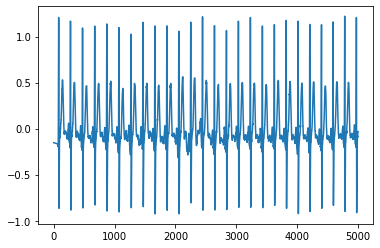

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(ecg_input)

## preop

In [ ]:
os.mkdir("../../cranberry2/Preprocessing/cache/peaks/PPG_100Hz_preop_2min_seg/")

In [105]:
vital_path = '../../cranberry2/Preprocessing/vital_data/preop_full_vital'
f_list = (os.listdir(vital_path))
vital = vitaldb.vital_recs(os.path.join(vital_path, f_list[0]), ['SNUADC/ECG_II'], interval=0.01).flatten()


array([       nan,        nan,        nan, ..., 0.12695312, 0.10742188,
       0.06835938])

In [ ]:
import os, sys
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pyvital2 import arr, vitaldb


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)


# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T


# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)


### input 설정
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 300 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수
SRATE = 100


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'vital_data/preop_full_vital'
cache_path = preprocess_path + 'vital_data/PPG_100Hz_ECG_100Hz_preop_2min'
ecg_path = preprocess_path + 'vital_data/ECG_250Hz_preop_2min'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


error_list = []
SRATE, f_num = 100, 100
initial = f_num
interval = 300
for f_vital in f_vital_list[initial:initial+interval]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    df_ecg = pickle.load(open(ecg_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
    
    
    ppg_cache = "../../cranberry2/Preprocessing/cache/peaks/PPG_100Hz_preop_2min_seg/" + f_vital
    ecg_cache = "../../cranberry2/Preprocessing/cache/peaks/ECG_100Hz_preop_2min_seg/" + f_vital    
    ecg_cache2 = "../../cranberry2/Preprocessing/cache/peaks/ECG_250Hz_preop_2min_seg/" + f_vital
 
    # 20초 단위로 끊기
    for i in range(n_aug):
        print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg = df_vital_input['PPG'].tolist()
        seg_ecg = df_vital_input['ECG'].tolist()
        
        
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            print('too much missing data')
            continue
    
    
    
        ### 2. Noise 처리 ###
        # peak detection
        if os.path.exists(ppg_cache+'_{}'.format(i+1)):
            _, ppg_peak = pickle.load(open(ppg_cache+'_{}'.format(i+1), 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_{}'.format(i+1), 'rb'))
            print('...loaded peak...', end='')
            

        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                
            
            except Exception as e:
                print('error of', e)
                error_list.append(f_vital)
                df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-3, -3])
                continue
                
            
            if len(ppg_peak)==0:
                print('no peak')
                
                
            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_{}'.format(i+1), 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_{}'.format(i+1), 'wb'))
            print('...saved peak...', end='')
            
        
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak
        
        
        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            print('too less peaks')
            continue

            
        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True
                
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)        
        print('preprocessing done...', end='')
        
        
'''        
        # 전처리 성공한 case에 대해 lowess filter 적용
        if bool_pass:
            print('passed...lowess filtering...', end='')
            save_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess6/pacu_'+f_vital
            if os.path.exists(save_path+'_{}'.format(i+1)):
                print('already exists')
                continue
                
                
            start_idx = i*OVERLAP*250
            end_idx = (i*OVERLAP + LEN_INPUT)*250
            seg_ecg2 = df_ecg.loc[start_idx:end_idx-1]
            ecg_inp = seg_ecg2[['ECG']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            
            try:
                ecg_peak2 = arr.detect_qrs(ecg_inp, 250)
                
            except Exception as e:
                print('error on 250Hz peak:', e)
                
            else:
                pickle.dump(ecg_peak2, open(ecg_cache2+'_{}'.format(i+1),'wb'))
            
            
            ppg_inp = pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            #ppg_inp = signal.resample(ppg_inp, 250*LEN_INPUT)
            
            
            ppg_input = ppg_inp - smooth(ppg_inp)
            ecg_input = ecg_inp - smooth(ecg_inp)
                                        
            
            pickle.dump([ppg_input, ecg_input],  open(save_path+'_{}'.format(i+1), 'wb'))
            print('done')
            
    
        else:
            print('failed')
'''        

    if f_num%500 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 10075')
        pickle.dump(df_preprocess, open('../DL_model/cache/preprocess6/df_preprocess_pacu_{}-{}'.format(initial, initial+interval), 'wb'))

        
print('dumping cache of d_preprocess -', f_num, '/ 10075')
pickle.dump(df_preprocess, open('../DL_model/cache/preprocess6/df_preprocess_pacu_{}-{}'.format(initial, initial+interval), 'wb'))


# Input

## input 1

### pacu

In [60]:
import statsmodels.api as sm


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)

# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T


import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
#sys.path.append('DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 300 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = '../DL_model/dataset/preprocess6/input/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_5min/ECG,'
    df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess6/df_preprocess_pacu_agender_pass','rb'))
    

    ### test set에 해당하는 file_path
    opid_test = pickle.load(open('../DL_model/opid_test', 'rb'))
    opid_train = pickle.load(open('../DL_model/opid_train', 'rb'))
    opid_val = pickle.load(open('../DL_model/opid_val', 'rb'))
    
    
    non_lis = []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []
    age_train_pacu, gender_train_pacu = [], []
    age_test_pacu, gender_test_pacu = [], []
    age_val_pacu, gender_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
            
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')
        f_vital = row['file_path']    
        
        lowess_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess6/pacu_'+f_vital
        
        
        for i in range(24,57):
            if row[str(i+1)][0]:
                ppg_input, ecg_input = pickle.load(open(lowess_path+'_{}'.format(str(i+1)),'rb'))
                ppg_input = signal.resample(ppg_input, LEN_INPUT*SRATE)
                
                ppg_input = ppg_input - np.nanmean(ppg_input)
                ecg_input = (ecg_input - np.nanmean(ecg_input)) / (max(ecg_input) - min(ecg_input))
        
                
                # 해당 opid가 test set에 속하는 경우
                if row['opid'] in opid_test:
                    age_test_pacu.append(int(row['age']))
                    if row['gender']=='F':
                        gender_test_pacu.append(1)
                    else:
                        gender_test_pacu.append(0)
                    x_test_pacu.append([ppg_input, ecg_input])
                    y_test_pacu.append((float(row['NRS'])))

                # 해당 opid가 train set에 해당하는 경우
                elif row['opid'] in opid_val:
                    age_val_pacu.append(int(row['age']))
                    if row['gender']=='F':
                        gender_val_pacu.append(1)
                    else:
                        gender_val_pacu.append(0)                    
                    x_val_pacu.append([ppg_input, ecg_input])
                    y_val_pacu.append((float(row['NRS'])))
                    
                elif row['opid'] in opid_train:
                    age_train_pacu.append(int(row['age']))
                    if row['gender']=='F':
                        gender_train_pacu.append(1)
                    else:
                        gender_train_pacu.append(0)                    
                    x_train_pacu.append([ppg_input, ecg_input])
                    y_train_pacu.append((float(row['NRS'])))
                    
                else:
                    print('no case%$')
                    non_lis.append(row['opid'])
                    
        print('completed')

    
    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, np.float32)
    y_test_pacu = np.array(y_test_pacu, np.float32)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, np.float32)
    
    age_train_pacu = np.array(age_train_pacu, int)
    age_test_pacu = np.array(age_test_pacu, int)
    age_val_pacu = np.array(age_val_pacu, int)
    gender_train_pacu = np.array(gender_train_pacu, int)
    gender_test_pacu = np.array(gender_test_pacu, int)
    gender_val_pacu = np.array(gender_val_pacu, int)
    
    
    # 알맞게 input 변환
    x_train_pacu = np.transpose(x_train_pacu, [0,2,1])
    x_val_pacu = np.transpose(x_val_pacu, [0,2,1])
    x_test_pacu = np.transpose(x_test_pacu, [0,2,1])

    print('after concatenate + transpose')
    print('x_train_pacu shape:', x_train_pacu.shape)
    print('x_val_pacu shape:', x_val_pacu.shape)
    print('x_test_pacu shape:', x_test_pacu.shape)

          
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    
    np.savez_compressed(input_path+'age_train_pacu.npz', age_train_pacu)
    np.savez_compressed(input_path+'age_test_pacu.npz', age_test_pacu)
    np.savez_compressed(input_path+'age_val_pacu.npz', age_val_pacu)    
    np.savez_compressed(input_path+'gender_train_pacu.npz', gender_train_pacu)
    np.savez_compressed(input_path+'gender_test_pacu.npz', gender_test_pacu)
    np.savez_compressed(input_path+'gender_val_pacu.npz', gender_val_pacu)    
    
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8090 ...completed
loading data 2/8090 ...completed
loading data 3/8090 ...completed
loading data 4/8090 ...completed
loading data 5/8090 ...completed
loading data 6/8090 ...completed
loading data 7/8090 ...completed
loading data 8/8090 ...completed
loading data 9/8090 ...completed
loading data 10/8090 ...completed
loading data 11/8090 ...completed
loading data 12/8090 ...completed
loading data 13/8090 ...completed
loading data 14/8090 ...completed
loading data 15/8090 ...completed
loading data 16/8090 ...completed
loading data 17/8090 ...completed
loading data 18/8090 ...completed
loading data 19/8090 ...completed
loading data 20/8090 ...completed
loading data 21/8090 ...completed
loading data 22/8090 ...completed
loading data 23/8090 ...completed
loading data 24/8090 ...completed
loading data 25/8090 ...completed
loading data 26/8090 ...completed
loading data 27/8090 ...completed
loading data 28/8090 ...completed
loading data 29/8090 ...completed
loading data 30/8090 ..

loading data 241/8090 ...completed
loading data 242/8090 ...completed
loading data 243/8090 ...completed
loading data 244/8090 ...completed
loading data 245/8090 ...completed
loading data 246/8090 ...completed
loading data 247/8090 ...completed
loading data 248/8090 ...completed
loading data 249/8090 ...completed
loading data 250/8090 ...completed
loading data 251/8090 ...completed
loading data 252/8090 ...completed
loading data 253/8090 ...completed
loading data 254/8090 ...completed
loading data 255/8090 ...completed
loading data 256/8090 ...completed
loading data 257/8090 ...completed
loading data 258/8090 ...completed
loading data 259/8090 ...completed
loading data 260/8090 ...completed
loading data 261/8090 ...completed
loading data 262/8090 ...completed
loading data 263/8090 ...completed
loading data 264/8090 ...completed
loading data 265/8090 ...completed
loading data 266/8090 ...completed
loading data 267/8090 ...completed
loading data 268/8090 ...completed
loading data 269/809

loading data 477/8090 ...completed
loading data 478/8090 ...completed
loading data 479/8090 ...completed
loading data 480/8090 ...completed
loading data 481/8090 ...completed
loading data 482/8090 ...completed
loading data 483/8090 ...completed
loading data 484/8090 ...completed
loading data 485/8090 ...completed
loading data 486/8090 ...completed
loading data 487/8090 ...completed
loading data 488/8090 ...completed
loading data 489/8090 ...completed
loading data 490/8090 ...completed
loading data 491/8090 ...completed
loading data 492/8090 ...completed
loading data 493/8090 ...completed
loading data 494/8090 ...completed
loading data 495/8090 ...completed
loading data 496/8090 ...completed
loading data 497/8090 ...completed
loading data 498/8090 ...completed
loading data 499/8090 ...completed
loading data 500/8090 ...completed
loading data 501/8090 ...completed
loading data 502/8090 ...completed
loading data 503/8090 ...completed
loading data 504/8090 ...completed
loading data 505/809

loading data 714/8090 ...completed
loading data 715/8090 ...completed
loading data 716/8090 ...completed
loading data 717/8090 ...completed
loading data 718/8090 ...completed
loading data 719/8090 ...completed
loading data 720/8090 ...completed
loading data 721/8090 ...completed
loading data 722/8090 ...completed
loading data 723/8090 ...completed
loading data 724/8090 ...completed
loading data 725/8090 ...completed
loading data 726/8090 ...completed
loading data 727/8090 ...completed
loading data 728/8090 ...completed
loading data 729/8090 ...completed
loading data 730/8090 ...completed
loading data 731/8090 ...completed
loading data 732/8090 ...completed
loading data 733/8090 ...completed
loading data 734/8090 ...completed
loading data 735/8090 ...completed
loading data 736/8090 ...completed
loading data 737/8090 ...completed
loading data 738/8090 ...completed
loading data 739/8090 ...completed
loading data 740/8090 ...completed
loading data 741/8090 ...completed
loading data 742/809

loading data 948/8090 ...completed
loading data 949/8090 ...completed
loading data 950/8090 ...completed
loading data 951/8090 ...completed
loading data 952/8090 ...completed
loading data 953/8090 ...completed
loading data 954/8090 ...completed
loading data 955/8090 ...completed
loading data 956/8090 ...completed
loading data 957/8090 ...completed
loading data 958/8090 ...completed
loading data 959/8090 ...completed
loading data 960/8090 ...completed
loading data 961/8090 ...completed
loading data 962/8090 ...completed
loading data 963/8090 ...completed
loading data 964/8090 ...completed
loading data 965/8090 ...completed
loading data 966/8090 ...completed
loading data 967/8090 ...completed
loading data 968/8090 ...completed
loading data 969/8090 ...completed
loading data 970/8090 ...completed
loading data 971/8090 ...completed
loading data 972/8090 ...completed
loading data 973/8090 ...completed
loading data 974/8090 ...completed
loading data 975/8090 ...completed
loading data 976/809

loading data 1178/8090 ...completed
loading data 1179/8090 ...completed
loading data 1180/8090 ...completed
loading data 1181/8090 ...completed
loading data 1182/8090 ...completed
loading data 1183/8090 ...completed
loading data 1184/8090 ...completed
loading data 1185/8090 ...completed
loading data 1186/8090 ...completed
loading data 1187/8090 ...completed
loading data 1188/8090 ...completed
loading data 1189/8090 ...completed
loading data 1190/8090 ...completed
loading data 1191/8090 ...completed
loading data 1192/8090 ...completed
loading data 1193/8090 ...completed
loading data 1194/8090 ...completed
loading data 1195/8090 ...completed
loading data 1196/8090 ...completed
loading data 1197/8090 ...completed
loading data 1198/8090 ...completed
loading data 1199/8090 ...completed
loading data 1200/8090 ...completed
loading data 1201/8090 ...completed
loading data 1202/8090 ...completed
loading data 1203/8090 ...completed
loading data 1204/8090 ...completed
loading data 1205/8090 ...co

loading data 1408/8090 ...completed
loading data 1409/8090 ...completed
loading data 1410/8090 ...completed
loading data 1411/8090 ...completed
loading data 1412/8090 ...completed
loading data 1413/8090 ...completed
loading data 1414/8090 ...completed
loading data 1415/8090 ...completed
loading data 1416/8090 ...completed
loading data 1417/8090 ...completed
loading data 1418/8090 ...completed
loading data 1419/8090 ...completed
loading data 1420/8090 ...completed
loading data 1421/8090 ...completed
loading data 1422/8090 ...completed
loading data 1423/8090 ...completed
loading data 1424/8090 ...completed
loading data 1425/8090 ...completed
loading data 1426/8090 ...completed
loading data 1427/8090 ...completed
loading data 1428/8090 ...completed
loading data 1429/8090 ...completed
loading data 1430/8090 ...completed
loading data 1431/8090 ...completed
loading data 1432/8090 ...completed
loading data 1433/8090 ...completed
loading data 1434/8090 ...completed
loading data 1435/8090 ...co

loading data 1637/8090 ...completed
loading data 1638/8090 ...completed
loading data 1639/8090 ...completed
loading data 1640/8090 ...completed
loading data 1641/8090 ...completed
loading data 1642/8090 ...completed
loading data 1643/8090 ...completed
loading data 1644/8090 ...completed
loading data 1645/8090 ...completed
loading data 1646/8090 ...completed
loading data 1647/8090 ...completed
loading data 1648/8090 ...completed
loading data 1649/8090 ...completed
loading data 1650/8090 ...completed
loading data 1651/8090 ...completed
loading data 1652/8090 ...completed
loading data 1653/8090 ...completed
loading data 1654/8090 ...completed
loading data 1655/8090 ...completed
loading data 1656/8090 ...completed
loading data 1657/8090 ...completed
loading data 1658/8090 ...completed
loading data 1659/8090 ...completed
loading data 1660/8090 ...completed
loading data 1661/8090 ...completed
loading data 1662/8090 ...completed
loading data 1663/8090 ...completed
loading data 1664/8090 ...co

loading data 1865/8090 ...completed
loading data 1866/8090 ...completed
loading data 1867/8090 ...completed
loading data 1868/8090 ...completed
loading data 1869/8090 ...completed
loading data 1870/8090 ...completed
loading data 1871/8090 ...completed
loading data 1872/8090 ...completed
loading data 1873/8090 ...completed
loading data 1874/8090 ...completed
loading data 1875/8090 ...completed
loading data 1876/8090 ...completed
loading data 1877/8090 ...completed
loading data 1878/8090 ...completed
loading data 1879/8090 ...completed
loading data 1880/8090 ...completed
loading data 1881/8090 ...completed
loading data 1882/8090 ...completed
loading data 1883/8090 ...completed
loading data 1884/8090 ...completed
loading data 1885/8090 ...completed
loading data 1886/8090 ...completed
loading data 1887/8090 ...completed
loading data 1888/8090 ...completed
loading data 1889/8090 ...completed
loading data 1890/8090 ...completed
loading data 1891/8090 ...completed
loading data 1892/8090 ...co

loading data 2092/8090 ...completed
loading data 2093/8090 ...completed
loading data 2094/8090 ...completed
loading data 2095/8090 ...completed
loading data 2096/8090 ...completed
loading data 2097/8090 ...completed
loading data 2098/8090 ...completed
loading data 2099/8090 ...completed
loading data 2100/8090 ...completed
loading data 2101/8090 ...completed
loading data 2102/8090 ...completed
loading data 2103/8090 ...completed
loading data 2104/8090 ...completed
loading data 2105/8090 ...completed
loading data 2106/8090 ...completed
loading data 2107/8090 ...completed
loading data 2108/8090 ...completed
loading data 2109/8090 ...completed
loading data 2110/8090 ...completed
loading data 2111/8090 ...completed
loading data 2112/8090 ...completed
loading data 2113/8090 ...completed
loading data 2114/8090 ...completed
loading data 2115/8090 ...completed
loading data 2116/8090 ...completed
loading data 2117/8090 ...completed
loading data 2118/8090 ...completed
loading data 2119/8090 ...co

loading data 2319/8090 ...completed
loading data 2320/8090 ...completed
loading data 2321/8090 ...completed
loading data 2322/8090 ...completed
loading data 2323/8090 ...completed
loading data 2324/8090 ...completed
loading data 2325/8090 ...completed
loading data 2326/8090 ...completed
loading data 2327/8090 ...completed
loading data 2328/8090 ...completed
loading data 2329/8090 ...completed
loading data 2330/8090 ...completed
loading data 2331/8090 ...completed
loading data 2332/8090 ...completed
loading data 2333/8090 ...completed
loading data 2334/8090 ...completed
loading data 2335/8090 ...completed
loading data 2336/8090 ...completed
loading data 2337/8090 ...completed
loading data 2338/8090 ...completed
loading data 2339/8090 ...completed
loading data 2340/8090 ...completed
loading data 2341/8090 ...completed
loading data 2342/8090 ...completed
loading data 2343/8090 ...completed
loading data 2344/8090 ...completed
loading data 2345/8090 ...completed
loading data 2346/8090 ...co

loading data 2546/8090 ...completed
loading data 2547/8090 ...completed
loading data 2548/8090 ...completed
loading data 2549/8090 ...completed
loading data 2550/8090 ...completed
loading data 2551/8090 ...completed
loading data 2552/8090 ...completed
loading data 2553/8090 ...completed
loading data 2554/8090 ...completed
loading data 2555/8090 ...completed
loading data 2556/8090 ...completed
loading data 2557/8090 ...completed
loading data 2558/8090 ...completed
loading data 2559/8090 ...completed
loading data 2560/8090 ...completed
loading data 2561/8090 ...completed
loading data 2562/8090 ...completed
loading data 2563/8090 ...completed
loading data 2564/8090 ...completed
loading data 2565/8090 ...completed
loading data 2566/8090 ...completed
loading data 2567/8090 ...completed
loading data 2568/8090 ...completed
loading data 2569/8090 ...completed
loading data 2570/8090 ...completed
loading data 2571/8090 ...completed
loading data 2572/8090 ...completed
loading data 2573/8090 ...co

loading data 2775/8090 ...completed
loading data 2776/8090 ...completed
loading data 2777/8090 ...completed
loading data 2778/8090 ...completed
loading data 2779/8090 ...completed
loading data 2780/8090 ...completed
loading data 2781/8090 ...completed
loading data 2782/8090 ...completed
loading data 2783/8090 ...completed
loading data 2784/8090 ...completed
loading data 2785/8090 ...completed
loading data 2786/8090 ...completed
loading data 2787/8090 ...completed
loading data 2788/8090 ...completed
loading data 2789/8090 ...completed
loading data 2790/8090 ...completed
loading data 2791/8090 ...completed
loading data 2792/8090 ...completed
loading data 2793/8090 ...completed
loading data 2794/8090 ...completed
loading data 2795/8090 ...completed
loading data 2796/8090 ...completed
loading data 2797/8090 ...completed
loading data 2798/8090 ...completed
loading data 2799/8090 ...completed
loading data 2800/8090 ...completed
loading data 2801/8090 ...completed
loading data 2802/8090 ...co

loading data 3002/8090 ...completed
loading data 3003/8090 ...completed
loading data 3004/8090 ...completed
loading data 3005/8090 ...completed
loading data 3006/8090 ...completed
loading data 3007/8090 ...completed
loading data 3008/8090 ...completed
loading data 3009/8090 ...completed
loading data 3010/8090 ...completed
loading data 3011/8090 ...completed
loading data 3012/8090 ...completed
loading data 3013/8090 ...completed
loading data 3014/8090 ...completed
loading data 3015/8090 ...completed
loading data 3016/8090 ...completed
loading data 3017/8090 ...completed
loading data 3018/8090 ...completed
loading data 3019/8090 ...completed
loading data 3020/8090 ...completed
loading data 3021/8090 ...completed
loading data 3022/8090 ...completed
loading data 3023/8090 ...completed
loading data 3024/8090 ...completed
loading data 3025/8090 ...completed
loading data 3026/8090 ...completed
loading data 3027/8090 ...completed
loading data 3028/8090 ...completed
loading data 3029/8090 ...co

loading data 3231/8090 ...completed
loading data 3232/8090 ...completed
loading data 3233/8090 ...completed
loading data 3234/8090 ...completed
loading data 3235/8090 ...completed
loading data 3236/8090 ...completed
loading data 3237/8090 ...completed
loading data 3238/8090 ...completed
loading data 3239/8090 ...completed
loading data 3240/8090 ...completed
loading data 3241/8090 ...completed
loading data 3242/8090 ...completed
loading data 3243/8090 ...completed
loading data 3244/8090 ...completed
loading data 3245/8090 ...completed
loading data 3246/8090 ...completed
loading data 3247/8090 ...completed
loading data 3248/8090 ...completed
loading data 3249/8090 ...completed
loading data 3250/8090 ...completed
loading data 3251/8090 ...completed
loading data 3252/8090 ...completed
loading data 3253/8090 ...completed
loading data 3254/8090 ...completed
loading data 3255/8090 ...completed
loading data 3256/8090 ...completed
loading data 3257/8090 ...completed
loading data 3258/8090 ...co

loading data 3459/8090 ...completed
loading data 3460/8090 ...completed
loading data 3461/8090 ...completed
loading data 3462/8090 ...completed
loading data 3463/8090 ...completed
loading data 3464/8090 ...completed
loading data 3465/8090 ...completed
loading data 3466/8090 ...completed
loading data 3467/8090 ...completed
loading data 3468/8090 ...completed
loading data 3469/8090 ...completed
loading data 3470/8090 ...completed
loading data 3471/8090 ...completed
loading data 3472/8090 ...completed
loading data 3473/8090 ...completed
loading data 3474/8090 ...completed
loading data 3475/8090 ...completed
loading data 3476/8090 ...completed
loading data 3477/8090 ...completed
loading data 3478/8090 ...completed
loading data 3479/8090 ...completed
loading data 3480/8090 ...completed
loading data 3481/8090 ...completed
loading data 3482/8090 ...completed
loading data 3483/8090 ...completed
loading data 3484/8090 ...completed
loading data 3485/8090 ...completed
loading data 3486/8090 ...co

loading data 3687/8090 ...completed
loading data 3688/8090 ...completed
loading data 3689/8090 ...completed
loading data 3690/8090 ...completed
loading data 3691/8090 ...completed
loading data 3692/8090 ...completed
loading data 3693/8090 ...completed
loading data 3694/8090 ...completed
loading data 3695/8090 ...completed
loading data 3696/8090 ...completed
loading data 3697/8090 ...completed
loading data 3698/8090 ...completed
loading data 3699/8090 ...completed
loading data 3700/8090 ...completed
loading data 3701/8090 ...completed
loading data 3702/8090 ...completed
loading data 3703/8090 ...completed
loading data 3704/8090 ...completed
loading data 3705/8090 ...completed
loading data 3706/8090 ...completed
loading data 3707/8090 ...completed
loading data 3708/8090 ...completed
loading data 3709/8090 ...completed
loading data 3710/8090 ...completed
loading data 3711/8090 ...completed
loading data 3712/8090 ...completed
loading data 3713/8090 ...completed
loading data 3714/8090 ...co

loading data 3917/8090 ...completed
loading data 3918/8090 ...completed
loading data 3919/8090 ...completed
loading data 3920/8090 ...completed
loading data 3921/8090 ...completed
loading data 3922/8090 ...completed
loading data 3923/8090 ...completed
loading data 3924/8090 ...completed
loading data 3925/8090 ...completed
loading data 3926/8090 ...completed
loading data 3927/8090 ...completed
loading data 3928/8090 ...completed
loading data 3929/8090 ...completed
loading data 3930/8090 ...completed
loading data 3931/8090 ...completed
loading data 3932/8090 ...completed
loading data 3933/8090 ...completed
loading data 3934/8090 ...completed
loading data 3935/8090 ...completed
loading data 3936/8090 ...completed
loading data 3937/8090 ...completed
loading data 3938/8090 ...completed
loading data 3939/8090 ...completed
loading data 3940/8090 ...completed
loading data 3941/8090 ...completed
loading data 3942/8090 ...completed
loading data 3943/8090 ...completed
loading data 3944/8090 ...co

loading data 4147/8090 ...completed
loading data 4148/8090 ...completed
loading data 4149/8090 ...completed
loading data 4150/8090 ...completed
loading data 4151/8090 ...completed
loading data 4152/8090 ...completed
loading data 4153/8090 ...completed
loading data 4154/8090 ...completed
loading data 4155/8090 ...completed
loading data 4156/8090 ...completed
loading data 4157/8090 ...completed
loading data 4158/8090 ...completed
loading data 4159/8090 ...completed
loading data 4160/8090 ...completed
loading data 4161/8090 ...completed
loading data 4162/8090 ...completed
loading data 4163/8090 ...completed
loading data 4164/8090 ...completed
loading data 4165/8090 ...completed
loading data 4166/8090 ...completed
loading data 4167/8090 ...completed
loading data 4168/8090 ...completed
loading data 4169/8090 ...completed
loading data 4170/8090 ...completed
loading data 4171/8090 ...completed
loading data 4172/8090 ...completed
loading data 4173/8090 ...completed
loading data 4174/8090 ...co

loading data 4376/8090 ...completed
loading data 4377/8090 ...completed
loading data 4378/8090 ...completed
loading data 4379/8090 ...completed
loading data 4380/8090 ...completed
loading data 4381/8090 ...completed
loading data 4382/8090 ...completed
loading data 4383/8090 ...completed
loading data 4384/8090 ...completed
loading data 4385/8090 ...completed
loading data 4386/8090 ...completed
loading data 4387/8090 ...completed
loading data 4388/8090 ...completed
loading data 4389/8090 ...completed
loading data 4390/8090 ...completed
loading data 4391/8090 ...completed
loading data 4392/8090 ...completed
loading data 4393/8090 ...completed
loading data 4394/8090 ...completed
loading data 4395/8090 ...completed
loading data 4396/8090 ...completed
loading data 4397/8090 ...completed
loading data 4398/8090 ...completed
loading data 4399/8090 ...completed
loading data 4400/8090 ...completed
loading data 4401/8090 ...completed
loading data 4402/8090 ...completed
loading data 4403/8090 ...co

loading data 4605/8090 ...completed
loading data 4606/8090 ...completed
loading data 4607/8090 ...completed
loading data 4608/8090 ...completed
loading data 4609/8090 ...completed
loading data 4610/8090 ...completed
loading data 4611/8090 ...completed
loading data 4612/8090 ...completed
loading data 4613/8090 ...completed
loading data 4614/8090 ...completed
loading data 4615/8090 ...completed
loading data 4616/8090 ...completed
loading data 4617/8090 ...completed
loading data 4618/8090 ...completed
loading data 4619/8090 ...completed
loading data 4620/8090 ...completed
loading data 4621/8090 ...completed
loading data 4622/8090 ...completed
loading data 4623/8090 ...completed
loading data 4624/8090 ...completed
loading data 4625/8090 ...completed
loading data 4626/8090 ...completed
loading data 4627/8090 ...completed
loading data 4628/8090 ...completed
loading data 4629/8090 ...completed
loading data 4630/8090 ...completed
loading data 4631/8090 ...completed
loading data 4632/8090 ...co

loading data 4834/8090 ...completed
loading data 4835/8090 ...completed
loading data 4836/8090 ...completed
loading data 4837/8090 ...completed
loading data 4838/8090 ...completed
loading data 4839/8090 ...completed
loading data 4840/8090 ...completed
loading data 4841/8090 ...completed
loading data 4842/8090 ...completed
loading data 4843/8090 ...completed
loading data 4844/8090 ...completed
loading data 4845/8090 ...completed
loading data 4846/8090 ...completed
loading data 4847/8090 ...completed
loading data 4848/8090 ...completed
loading data 4849/8090 ...completed
loading data 4850/8090 ...completed
loading data 4851/8090 ...completed
loading data 4852/8090 ...completed
loading data 4853/8090 ...completed
loading data 4854/8090 ...completed
loading data 4855/8090 ...completed
loading data 4856/8090 ...completed
loading data 4857/8090 ...completed
loading data 4858/8090 ...completed
loading data 4859/8090 ...completed
loading data 4860/8090 ...completed
loading data 4861/8090 ...co

loading data 5064/8090 ...completed
loading data 5065/8090 ...completed
loading data 5066/8090 ...completed
loading data 5067/8090 ...completed
loading data 5068/8090 ...completed
loading data 5069/8090 ...completed
loading data 5070/8090 ...completed
loading data 5071/8090 ...completed
loading data 5072/8090 ...completed
loading data 5073/8090 ...completed
loading data 5074/8090 ...completed
loading data 5075/8090 ...completed
loading data 5076/8090 ...completed
loading data 5077/8090 ...completed
loading data 5078/8090 ...completed
loading data 5079/8090 ...completed
loading data 5080/8090 ...completed
loading data 5081/8090 ...completed
loading data 5082/8090 ...completed
loading data 5083/8090 ...completed
loading data 5084/8090 ...completed
loading data 5085/8090 ...completed
loading data 5086/8090 ...completed
loading data 5087/8090 ...completed
loading data 5088/8090 ...completed
loading data 5089/8090 ...completed
loading data 5090/8090 ...completed
loading data 5091/8090 ...co

loading data 5291/8090 ...completed
loading data 5292/8090 ...completed
loading data 5293/8090 ...completed
loading data 5294/8090 ...completed
loading data 5295/8090 ...completed
loading data 5296/8090 ...completed
loading data 5297/8090 ...completed
loading data 5298/8090 ...completed
loading data 5299/8090 ...completed
loading data 5300/8090 ...completed
loading data 5301/8090 ...completed
loading data 5302/8090 ...completed
loading data 5303/8090 ...completed
loading data 5304/8090 ...completed
loading data 5305/8090 ...completed
loading data 5306/8090 ...completed
loading data 5307/8090 ...completed
loading data 5308/8090 ...completed
loading data 5309/8090 ...completed
loading data 5310/8090 ...completed
loading data 5311/8090 ...completed
loading data 5312/8090 ...completed
loading data 5313/8090 ...completed
loading data 5314/8090 ...completed
loading data 5315/8090 ...completed
loading data 5316/8090 ...completed
loading data 5317/8090 ...completed
loading data 5318/8090 ...co

loading data 5522/8090 ...completed
loading data 5523/8090 ...completed
loading data 5524/8090 ...completed
loading data 5525/8090 ...completed
loading data 5526/8090 ...completed
loading data 5527/8090 ...completed
loading data 5528/8090 ...completed
loading data 5529/8090 ...completed
loading data 5530/8090 ...completed
loading data 5531/8090 ...completed
loading data 5532/8090 ...completed
loading data 5533/8090 ...completed
loading data 5534/8090 ...completed
loading data 5535/8090 ...completed
loading data 5536/8090 ...completed
loading data 5537/8090 ...completed
loading data 5538/8090 ...completed
loading data 5539/8090 ...completed
loading data 5540/8090 ...completed
loading data 5541/8090 ...completed
loading data 5542/8090 ...completed
loading data 5543/8090 ...completed
loading data 5544/8090 ...completed
loading data 5545/8090 ...completed
loading data 5546/8090 ...completed
loading data 5547/8090 ...completed
loading data 5548/8090 ...completed
loading data 5549/8090 ...co

loading data 5750/8090 ...completed
loading data 5751/8090 ...completed
loading data 5752/8090 ...completed
loading data 5753/8090 ...completed
loading data 5754/8090 ...completed
loading data 5755/8090 ...completed
loading data 5756/8090 ...completed
loading data 5757/8090 ...completed
loading data 5758/8090 ...completed
loading data 5759/8090 ...completed
loading data 5760/8090 ...completed
loading data 5761/8090 ...completed
loading data 5762/8090 ...completed
loading data 5763/8090 ...completed
loading data 5764/8090 ...completed
loading data 5765/8090 ...completed
loading data 5766/8090 ...completed
loading data 5767/8090 ...completed
loading data 5768/8090 ...completed
loading data 5769/8090 ...completed
loading data 5770/8090 ...completed
loading data 5771/8090 ...completed
loading data 5772/8090 ...completed
loading data 5773/8090 ...completed
loading data 5774/8090 ...completed
loading data 5775/8090 ...completed
loading data 5776/8090 ...completed
loading data 5777/8090 ...co

loading data 5977/8090 ...completed
loading data 5978/8090 ...completed
loading data 5979/8090 ...completed
loading data 5980/8090 ...completed
loading data 5981/8090 ...completed
loading data 5982/8090 ...completed
loading data 5983/8090 ...completed
loading data 5984/8090 ...completed
loading data 5985/8090 ...completed
loading data 5986/8090 ...completed
loading data 5987/8090 ...completed
loading data 5988/8090 ...completed
loading data 5989/8090 ...completed
loading data 5990/8090 ...completed
loading data 5991/8090 ...completed
loading data 5992/8090 ...completed
loading data 5993/8090 ...completed
loading data 5994/8090 ...completed
loading data 5995/8090 ...completed
loading data 5996/8090 ...completed
loading data 5997/8090 ...completed
loading data 5998/8090 ...completed
loading data 5999/8090 ...completed
loading data 6000/8090 ...completed
loading data 6001/8090 ...completed
loading data 6002/8090 ...completed
loading data 6003/8090 ...completed
loading data 6004/8090 ...co

loading data 6207/8090 ...completed
loading data 6208/8090 ...completed
loading data 6209/8090 ...completed
loading data 6210/8090 ...completed
loading data 6211/8090 ...completed
loading data 6212/8090 ...completed
loading data 6213/8090 ...completed
loading data 6214/8090 ...completed
loading data 6215/8090 ...completed
loading data 6216/8090 ...completed
loading data 6217/8090 ...completed
loading data 6218/8090 ...completed
loading data 6219/8090 ...completed
loading data 6220/8090 ...completed
loading data 6221/8090 ...completed
loading data 6222/8090 ...completed
loading data 6223/8090 ...completed
loading data 6224/8090 ...completed
loading data 6225/8090 ...completed
loading data 6226/8090 ...completed
loading data 6227/8090 ...completed
loading data 6228/8090 ...completed
loading data 6229/8090 ...completed
loading data 6230/8090 ...completed
loading data 6231/8090 ...completed
loading data 6232/8090 ...completed
loading data 6233/8090 ...completed
loading data 6234/8090 ...co

loading data 6436/8090 ...completed
loading data 6437/8090 ...completed
loading data 6438/8090 ...completed
loading data 6439/8090 ...completed
loading data 6440/8090 ...completed
loading data 6441/8090 ...completed
loading data 6442/8090 ...completed
loading data 6443/8090 ...completed
loading data 6444/8090 ...completed
loading data 6445/8090 ...completed
loading data 6446/8090 ...completed
loading data 6447/8090 ...completed
loading data 6448/8090 ...completed
loading data 6449/8090 ...completed
loading data 6450/8090 ...completed
loading data 6451/8090 ...completed
loading data 6452/8090 ...completed
loading data 6453/8090 ...completed
loading data 6454/8090 ...completed
loading data 6455/8090 ...completed
loading data 6456/8090 ...completed
loading data 6457/8090 ...completed
loading data 6458/8090 ...completed
loading data 6459/8090 ...completed
loading data 6460/8090 ...completed
loading data 6461/8090 ...completed
loading data 6462/8090 ...completed
loading data 6463/8090 ...co

loading data 6666/8090 ...completed
loading data 6667/8090 ...completed
loading data 6668/8090 ...completed
loading data 6669/8090 ...completed
loading data 6670/8090 ...completed
loading data 6671/8090 ...completed
loading data 6672/8090 ...completed
loading data 6673/8090 ...completed
loading data 6674/8090 ...completed
loading data 6675/8090 ...completed
loading data 6676/8090 ...completed
loading data 6677/8090 ...completed
loading data 6678/8090 ...completed
loading data 6679/8090 ...completed
loading data 6680/8090 ...completed
loading data 6681/8090 ...completed
loading data 6682/8090 ...completed
loading data 6683/8090 ...completed
loading data 6684/8090 ...completed
loading data 6685/8090 ...completed
loading data 6686/8090 ...completed
loading data 6687/8090 ...completed
loading data 6688/8090 ...completed
loading data 6689/8090 ...completed
loading data 6690/8090 ...completed
loading data 6691/8090 ...completed
loading data 6692/8090 ...completed
loading data 6693/8090 ...co

loading data 6894/8090 ...completed
loading data 6895/8090 ...completed
loading data 6896/8090 ...completed
loading data 6897/8090 ...completed
loading data 6898/8090 ...completed
loading data 6899/8090 ...completed
loading data 6900/8090 ...completed
loading data 6901/8090 ...completed
loading data 6902/8090 ...completed
loading data 6903/8090 ...completed
loading data 6904/8090 ...completed
loading data 6905/8090 ...completed
loading data 6906/8090 ...completed
loading data 6907/8090 ...completed
loading data 6908/8090 ...completed
loading data 6909/8090 ...completed
loading data 6910/8090 ...completed
loading data 6911/8090 ...completed
loading data 6912/8090 ...completed
loading data 6913/8090 ...completed
loading data 6914/8090 ...completed
loading data 6915/8090 ...completed
loading data 6916/8090 ...completed
loading data 6917/8090 ...completed
loading data 6918/8090 ...completed
loading data 6919/8090 ...completed
loading data 6920/8090 ...completed
loading data 6921/8090 ...co

loading data 7121/8090 ...completed
loading data 7122/8090 ...completed
loading data 7123/8090 ...completed
loading data 7124/8090 ...completed
loading data 7125/8090 ...completed
loading data 7126/8090 ...completed
loading data 7127/8090 ...completed
loading data 7128/8090 ...completed
loading data 7129/8090 ...completed
loading data 7130/8090 ...completed
loading data 7131/8090 ...completed
loading data 7132/8090 ...completed
loading data 7133/8090 ...completed
loading data 7134/8090 ...completed
loading data 7135/8090 ...completed
loading data 7136/8090 ...completed
loading data 7137/8090 ...completed
loading data 7138/8090 ...completed
loading data 7139/8090 ...completed
loading data 7140/8090 ...completed
loading data 7141/8090 ...completed
loading data 7142/8090 ...completed
loading data 7143/8090 ...completed
loading data 7144/8090 ...completed
loading data 7145/8090 ...completed
loading data 7146/8090 ...completed
loading data 7147/8090 ...completed
loading data 7148/8090 ...co

loading data 7349/8090 ...completed
loading data 7350/8090 ...completed
loading data 7351/8090 ...completed
loading data 7352/8090 ...completed
loading data 7353/8090 ...completed
loading data 7354/8090 ...completed
loading data 7355/8090 ...completed
loading data 7356/8090 ...completed
loading data 7357/8090 ...completed
loading data 7358/8090 ...completed
loading data 7359/8090 ...completed
loading data 7360/8090 ...completed
loading data 7361/8090 ...completed
loading data 7362/8090 ...completed
loading data 7363/8090 ...completed
loading data 7364/8090 ...completed
loading data 7365/8090 ...completed
loading data 7366/8090 ...completed
loading data 7367/8090 ...completed
loading data 7368/8090 ...completed
loading data 7369/8090 ...completed
loading data 7370/8090 ...completed
loading data 7371/8090 ...completed
loading data 7372/8090 ...completed
loading data 7373/8090 ...completed
loading data 7374/8090 ...completed
loading data 7375/8090 ...completed
loading data 7376/8090 ...co

loading data 7577/8090 ...completed
loading data 7578/8090 ...completed
loading data 7579/8090 ...completed
loading data 7580/8090 ...completed
loading data 7581/8090 ...completed
loading data 7582/8090 ...completed
loading data 7583/8090 ...completed
loading data 7584/8090 ...completed
loading data 7585/8090 ...completed
loading data 7586/8090 ...completed
loading data 7587/8090 ...completed
loading data 7588/8090 ...completed
loading data 7589/8090 ...completed
loading data 7590/8090 ...completed
loading data 7591/8090 ...completed
loading data 7592/8090 ...completed
loading data 7593/8090 ...completed
loading data 7594/8090 ...completed
loading data 7595/8090 ...completed
loading data 7596/8090 ...completed
loading data 7597/8090 ...completed
loading data 7598/8090 ...completed
loading data 7599/8090 ...completed
loading data 7600/8090 ...completed
loading data 7601/8090 ...completed
loading data 7602/8090 ...completed
loading data 7603/8090 ...completed
loading data 7604/8090 ...co

loading data 7808/8090 ...completed
loading data 7809/8090 ...completed
loading data 7810/8090 ...completed
loading data 7811/8090 ...completed
loading data 7812/8090 ...completed
loading data 7813/8090 ...completed
loading data 7814/8090 ...completed
loading data 7815/8090 ...completed
loading data 7816/8090 ...completed
loading data 7817/8090 ...completed
loading data 7818/8090 ...completed
loading data 7819/8090 ...completed
loading data 7820/8090 ...completed
loading data 7821/8090 ...completed
loading data 7822/8090 ...completed
loading data 7823/8090 ...completed
loading data 7824/8090 ...completed
loading data 7825/8090 ...completed
loading data 7826/8090 ...completed
loading data 7827/8090 ...completed
loading data 7828/8090 ...completed
loading data 7829/8090 ...completed
loading data 7830/8090 ...completed
loading data 7831/8090 ...completed
loading data 7832/8090 ...completed
loading data 7833/8090 ...completed
loading data 7834/8090 ...completed
loading data 7835/8090 ...co

loading data 8038/8090 ...completed
loading data 8039/8090 ...completed
loading data 8040/8090 ...completed
loading data 8041/8090 ...completed
loading data 8042/8090 ...completed
loading data 8043/8090 ...completed
loading data 8044/8090 ...completed
loading data 8045/8090 ...completed
loading data 8046/8090 ...completed
loading data 8047/8090 ...completed
loading data 8048/8090 ...completed
loading data 8049/8090 ...completed
loading data 8050/8090 ...completed
loading data 8051/8090 ...completed
loading data 8052/8090 ...completed
loading data 8053/8090 ...completed
loading data 8054/8090 ...completed
loading data 8055/8090 ...completed
loading data 8056/8090 ...completed
loading data 8057/8090 ...completed
loading data 8058/8090 ...completed
loading data 8059/8090 ...completed
loading data 8060/8090 ...completed
loading data 8061/8090 ...completed
loading data 8062/8090 ...completed
loading data 8063/8090 ...completed
loading data 8064/8090 ...completed
loading data 8065/8090 ...co

In [89]:
100*np.mean(y_train_pacu>=4), 100*np.mean(y_val_pacu>=4), 100*np.mean(y_test_pacu>=4)

(79.6308733179116, 80.92927510660198, 81.69673598677868)

## input2

### pacu

In [97]:
import statsmodels.api as sm


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)

# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T


import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
#sys.path.append('DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 300 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = '../DL_model/dataset/preprocess6/input2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_5min/ECG,'
    df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess6/df_preprocess_pacu_agender_pass','rb'))
    

    ### test set에 해당하는 file_path
    opid_test = pickle.load(open('../DL_model/opid_test', 'rb'))
    opid_train = pickle.load(open('../DL_model/opid_train', 'rb'))
    opid_val = pickle.load(open('../DL_model/opid_val', 'rb'))
    
    
    non_lis = []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []
    age_train_pacu, gender_train_pacu = [], []
    age_test_pacu, gender_test_pacu = [], []
    age_val_pacu, gender_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
            
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')
        f_vital = row['file_path']    
        
        lowess_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess6/pacu_'+f_vital
        
        
        for i in range(24,57):
            if row[str(i+1)][0]:
                ppg_input, ecg_input = pickle.load(open(lowess_path+'_{}'.format(str(i+1)),'rb'))
                ppg_input = signal.resample(ppg_input, LEN_INPUT*SRATE)
                
                ppg_input = ppg_input - np.nanmean(ppg_input)
                ecg_input = (ecg_input - np.nanmean(ecg_input)) / np.nanstd(ecg_input)
        
                
                # 해당 opid가 test set에 속하는 경우
                if row['opid'] in opid_test:
                    age_test_pacu.append(int(row['age']))
                    if row['gender']=='F':
                        gender_test_pacu.append(1)
                    else:
                        gender_test_pacu.append(0)
                    x_test_pacu.append([ppg_input, ecg_input])
                    y_test_pacu.append((float(row['NRS'])))

                # 해당 opid가 train set에 해당하는 경우
                elif row['opid'] in opid_val:
                    age_val_pacu.append(int(row['age']))
                    if row['gender']=='F':
                        gender_val_pacu.append(1)
                    else:
                        gender_val_pacu.append(0)                    
                    x_val_pacu.append([ppg_input, ecg_input])
                    y_val_pacu.append((float(row['NRS'])))
                    
                elif row['opid'] in opid_train:
                    age_train_pacu.append(int(row['age']))
                    if row['gender']=='F':
                        gender_train_pacu.append(1)
                    else:
                        gender_train_pacu.append(0)                    
                    x_train_pacu.append([ppg_input, ecg_input])
                    y_train_pacu.append((float(row['NRS'])))
                    
                else:
                    print('no case%$')
                    non_lis.append(row['opid'])
                    
        print('completed')

    
    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, np.float32)
    y_test_pacu = np.array(y_test_pacu, np.float32)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, np.float32)
    
    age_train_pacu = np.array(age_train_pacu, int)
    age_test_pacu = np.array(age_test_pacu, int)
    age_val_pacu = np.array(age_val_pacu, int)
    gender_train_pacu = np.array(gender_train_pacu, int)
    gender_test_pacu = np.array(gender_test_pacu, int)
    gender_val_pacu = np.array(gender_val_pacu, int)
    
    
    # 알맞게 input 변환
    x_train_pacu = np.transpose(x_train_pacu, [0,2,1])
    x_val_pacu = np.transpose(x_val_pacu, [0,2,1])
    x_test_pacu = np.transpose(x_test_pacu, [0,2,1])

    print('after concatenate + transpose')
    print('x_train_pacu shape:', x_train_pacu.shape)
    print('x_val_pacu shape:', x_val_pacu.shape)
    print('x_test_pacu shape:', x_test_pacu.shape)

          
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    
    np.savez_compressed(input_path+'age_train_pacu.npz', age_train_pacu)
    np.savez_compressed(input_path+'age_test_pacu.npz', age_test_pacu)
    np.savez_compressed(input_path+'age_val_pacu.npz', age_val_pacu)    
    np.savez_compressed(input_path+'gender_train_pacu.npz', gender_train_pacu)
    np.savez_compressed(input_path+'gender_test_pacu.npz', gender_test_pacu)
    np.savez_compressed(input_path+'gender_val_pacu.npz', gender_val_pacu)    
    
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8090 ...completed
loading data 2/8090 ...completed
loading data 3/8090 ...completed
loading data 4/8090 ...completed
loading data 5/8090 ...completed
loading data 6/8090 ...completed
loading data 7/8090 ...completed
loading data 8/8090 ...completed
loading data 9/8090 ...completed
loading data 10/8090 ...completed
loading data 11/8090 ...completed
loading data 12/8090 ...completed
loading data 13/8090 ...completed
loading data 14/8090 ...completed
loading data 15/8090 ...completed
loading data 16/8090 ...completed
loading data 17/8090 ...completed
loading data 18/8090 ...completed
loading data 19/8090 ...completed
loading data 20/8090 ...completed
loading data 21/8090 ...completed
loading data 22/8090 ...completed
loading data 23/8090 ...completed
loading data 24/8090 ...completed
loading data 25/8090 ...completed
loading data 26/8090 ...completed
loading data 27/8090 ...completed
loading data 28/8090 ...completed
loading data 29/8090 ...completed
loading data 30/8090 ..

loading data 249/8090 ...completed
loading data 250/8090 ...completed
loading data 251/8090 ...completed
loading data 252/8090 ...completed
loading data 253/8090 ...completed
loading data 254/8090 ...completed
loading data 255/8090 ...completed
loading data 256/8090 ...completed
loading data 257/8090 ...completed
loading data 258/8090 ...completed
loading data 259/8090 ...completed
loading data 260/8090 ...completed
loading data 261/8090 ...completed
loading data 262/8090 ...completed
loading data 263/8090 ...completed
loading data 264/8090 ...completed
loading data 265/8090 ...completed
loading data 266/8090 ...completed
loading data 267/8090 ...completed
loading data 268/8090 ...completed
loading data 269/8090 ...completed
loading data 270/8090 ...completed
loading data 271/8090 ...completed
loading data 272/8090 ...completed
loading data 273/8090 ...completed
loading data 274/8090 ...completed
loading data 275/8090 ...completed
loading data 276/8090 ...completed
loading data 277/809

loading data 488/8090 ...completed
loading data 489/8090 ...completed
loading data 490/8090 ...completed
loading data 491/8090 ...completed
loading data 492/8090 ...completed
loading data 493/8090 ...completed
loading data 494/8090 ...completed
loading data 495/8090 ...completed
loading data 496/8090 ...completed
loading data 497/8090 ...completed
loading data 498/8090 ...completed
loading data 499/8090 ...completed
loading data 500/8090 ...completed
loading data 501/8090 ...completed
loading data 502/8090 ...completed
loading data 503/8090 ...completed
loading data 504/8090 ...completed
loading data 505/8090 ...completed
loading data 506/8090 ...completed
loading data 507/8090 ...completed
loading data 508/8090 ...completed
loading data 509/8090 ...completed
loading data 510/8090 ...completed
loading data 511/8090 ...completed
loading data 512/8090 ...completed
loading data 513/8090 ...completed
loading data 514/8090 ...completed
loading data 515/8090 ...completed
loading data 516/809

loading data 727/8090 ...completed
loading data 728/8090 ...completed
loading data 729/8090 ...completed
loading data 730/8090 ...completed
loading data 731/8090 ...completed
loading data 732/8090 ...completed
loading data 733/8090 ...completed
loading data 734/8090 ...completed
loading data 735/8090 ...completed
loading data 736/8090 ...completed
loading data 737/8090 ...completed
loading data 738/8090 ...completed
loading data 739/8090 ...completed
loading data 740/8090 ...completed
loading data 741/8090 ...completed
loading data 742/8090 ...completed
loading data 743/8090 ...completed
loading data 744/8090 ...completed
loading data 745/8090 ...completed
loading data 746/8090 ...completed
loading data 747/8090 ...completed
loading data 748/8090 ...completed
loading data 749/8090 ...completed
loading data 750/8090 ...completed
loading data 751/8090 ...completed
loading data 752/8090 ...completed
loading data 753/8090 ...completed
loading data 754/8090 ...completed
loading data 755/809

loading data 962/8090 ...completed
loading data 963/8090 ...completed
loading data 964/8090 ...completed
loading data 965/8090 ...completed
loading data 966/8090 ...completed
loading data 967/8090 ...completed
loading data 968/8090 ...completed
loading data 969/8090 ...completed
loading data 970/8090 ...completed
loading data 971/8090 ...completed
loading data 972/8090 ...completed
loading data 973/8090 ...completed
loading data 974/8090 ...completed
loading data 975/8090 ...completed
loading data 976/8090 ...completed
loading data 977/8090 ...completed
loading data 978/8090 ...completed
loading data 979/8090 ...completed
loading data 980/8090 ...completed
loading data 981/8090 ...completed
loading data 982/8090 ...completed
loading data 983/8090 ...completed
loading data 984/8090 ...completed
loading data 985/8090 ...completed
loading data 986/8090 ...completed
loading data 987/8090 ...completed
loading data 988/8090 ...completed
loading data 989/8090 ...completed
loading data 990/809

loading data 1197/8090 ...completed
loading data 1198/8090 ...completed
loading data 1199/8090 ...completed
loading data 1200/8090 ...completed
loading data 1201/8090 ...completed
loading data 1202/8090 ...completed
loading data 1203/8090 ...completed
loading data 1204/8090 ...completed
loading data 1205/8090 ...completed
loading data 1206/8090 ...completed
loading data 1207/8090 ...completed
loading data 1208/8090 ...completed
loading data 1209/8090 ...completed
loading data 1210/8090 ...completed
loading data 1211/8090 ...completed
loading data 1212/8090 ...completed
loading data 1213/8090 ...completed
loading data 1214/8090 ...completed
loading data 1215/8090 ...completed
loading data 1216/8090 ...completed
loading data 1217/8090 ...completed
loading data 1218/8090 ...completed
loading data 1219/8090 ...completed
loading data 1220/8090 ...completed
loading data 1221/8090 ...completed
loading data 1222/8090 ...completed
loading data 1223/8090 ...completed
loading data 1224/8090 ...co

loading data 1429/8090 ...completed
loading data 1430/8090 ...completed
loading data 1431/8090 ...completed
loading data 1432/8090 ...completed
loading data 1433/8090 ...completed
loading data 1434/8090 ...completed
loading data 1435/8090 ...completed
loading data 1436/8090 ...completed
loading data 1437/8090 ...completed
loading data 1438/8090 ...completed
loading data 1439/8090 ...completed
loading data 1440/8090 ...completed
loading data 1441/8090 ...completed
loading data 1442/8090 ...completed
loading data 1443/8090 ...completed
loading data 1444/8090 ...completed
loading data 1445/8090 ...completed
loading data 1446/8090 ...completed
loading data 1447/8090 ...completed
loading data 1448/8090 ...completed
loading data 1449/8090 ...completed
loading data 1450/8090 ...completed
loading data 1451/8090 ...completed
loading data 1452/8090 ...completed
loading data 1453/8090 ...completed
loading data 1454/8090 ...completed
loading data 1455/8090 ...completed
loading data 1456/8090 ...co

loading data 1664/8090 ...completed
loading data 1665/8090 ...completed
loading data 1666/8090 ...completed
loading data 1667/8090 ...completed
loading data 1668/8090 ...completed
loading data 1669/8090 ...completed
loading data 1670/8090 ...completed
loading data 1671/8090 ...completed
loading data 1672/8090 ...completed
loading data 1673/8090 ...completed
loading data 1674/8090 ...completed
loading data 1675/8090 ...completed
loading data 1676/8090 ...completed
loading data 1677/8090 ...completed
loading data 1678/8090 ...completed
loading data 1679/8090 ...completed
loading data 1680/8090 ...completed
loading data 1681/8090 ...completed
loading data 1682/8090 ...completed
loading data 1683/8090 ...completed
loading data 1684/8090 ...completed
loading data 1685/8090 ...completed
loading data 1686/8090 ...completed
loading data 1687/8090 ...completed
loading data 1688/8090 ...completed
loading data 1689/8090 ...completed
loading data 1690/8090 ...completed
loading data 1691/8090 ...co

loading data 1892/8090 ...completed
loading data 1893/8090 ...completed
loading data 1894/8090 ...completed
loading data 1895/8090 ...completed
loading data 1896/8090 ...completed
loading data 1897/8090 ...completed
loading data 1898/8090 ...completed
loading data 1899/8090 ...completed
loading data 1900/8090 ...completed
loading data 1901/8090 ...completed
loading data 1902/8090 ...completed
loading data 1903/8090 ...completed
loading data 1904/8090 ...completed
loading data 1905/8090 ...completed
loading data 1906/8090 ...completed
loading data 1907/8090 ...completed
loading data 1908/8090 ...completed
loading data 1909/8090 ...completed
loading data 1910/8090 ...completed
loading data 1911/8090 ...completed
loading data 1912/8090 ...completed
loading data 1913/8090 ...completed
loading data 1914/8090 ...completed
loading data 1915/8090 ...completed
loading data 1916/8090 ...completed
loading data 1917/8090 ...completed
loading data 1918/8090 ...completed
loading data 1919/8090 ...co

loading data 2125/8090 ...completed
loading data 2126/8090 ...completed
loading data 2127/8090 ...completed
loading data 2128/8090 ...completed
loading data 2129/8090 ...completed
loading data 2130/8090 ...completed
loading data 2131/8090 ...completed
loading data 2132/8090 ...completed
loading data 2133/8090 ...completed
loading data 2134/8090 ...completed
loading data 2135/8090 ...completed
loading data 2136/8090 ...completed
loading data 2137/8090 ...completed
loading data 2138/8090 ...completed
loading data 2139/8090 ...completed
loading data 2140/8090 ...completed
loading data 2141/8090 ...completed
loading data 2142/8090 ...completed
loading data 2143/8090 ...completed
loading data 2144/8090 ...completed
loading data 2145/8090 ...completed
loading data 2146/8090 ...completed
loading data 2147/8090 ...completed
loading data 2148/8090 ...completed
loading data 2149/8090 ...completed
loading data 2150/8090 ...completed
loading data 2151/8090 ...completed
loading data 2152/8090 ...co

loading data 2361/8090 ...completed
loading data 2362/8090 ...completed
loading data 2363/8090 ...completed
loading data 2364/8090 ...completed
loading data 2365/8090 ...completed
loading data 2366/8090 ...completed
loading data 2367/8090 ...completed
loading data 2368/8090 ...completed
loading data 2369/8090 ...completed
loading data 2370/8090 ...completed
loading data 2371/8090 ...completed
loading data 2372/8090 ...completed
loading data 2373/8090 ...completed
loading data 2374/8090 ...completed
loading data 2375/8090 ...completed
loading data 2376/8090 ...completed
loading data 2377/8090 ...completed
loading data 2378/8090 ...completed
loading data 2379/8090 ...completed
loading data 2380/8090 ...completed
loading data 2381/8090 ...completed
loading data 2382/8090 ...completed
loading data 2383/8090 ...completed
loading data 2384/8090 ...completed
loading data 2385/8090 ...completed
loading data 2386/8090 ...completed
loading data 2387/8090 ...completed
loading data 2388/8090 ...co

loading data 2597/8090 ...completed
loading data 2598/8090 ...completed
loading data 2599/8090 ...completed
loading data 2600/8090 ...completed
loading data 2601/8090 ...completed
loading data 2602/8090 ...completed
loading data 2603/8090 ...completed
loading data 2604/8090 ...completed
loading data 2605/8090 ...completed
loading data 2606/8090 ...completed
loading data 2607/8090 ...completed
loading data 2608/8090 ...completed
loading data 2609/8090 ...completed
loading data 2610/8090 ...completed
loading data 2611/8090 ...completed
loading data 2612/8090 ...completed
loading data 2613/8090 ...completed
loading data 2614/8090 ...completed
loading data 2615/8090 ...completed
loading data 2616/8090 ...completed
loading data 2617/8090 ...completed
loading data 2618/8090 ...completed
loading data 2619/8090 ...completed
loading data 2620/8090 ...completed
loading data 2621/8090 ...completed
loading data 2622/8090 ...completed
loading data 2623/8090 ...completed
loading data 2624/8090 ...co

loading data 2826/8090 ...completed
loading data 2827/8090 ...completed
loading data 2828/8090 ...completed
loading data 2829/8090 ...completed
loading data 2830/8090 ...completed
loading data 2831/8090 ...completed
loading data 2832/8090 ...completed
loading data 2833/8090 ...completed
loading data 2834/8090 ...completed
loading data 2835/8090 ...completed
loading data 2836/8090 ...completed
loading data 2837/8090 ...completed
loading data 2838/8090 ...completed
loading data 2839/8090 ...completed
loading data 2840/8090 ...completed
loading data 2841/8090 ...completed
loading data 2842/8090 ...completed
loading data 2843/8090 ...completed
loading data 2844/8090 ...completed
loading data 2845/8090 ...completed
loading data 2846/8090 ...completed
loading data 2847/8090 ...completed
loading data 2848/8090 ...completed
loading data 2849/8090 ...completed
loading data 2850/8090 ...completed
loading data 2851/8090 ...completed
loading data 2852/8090 ...completed
loading data 2853/8090 ...co

loading data 3064/8090 ...completed
loading data 3065/8090 ...completed
loading data 3066/8090 ...completed
loading data 3067/8090 ...completed
loading data 3068/8090 ...completed
loading data 3069/8090 ...completed
loading data 3070/8090 ...completed
loading data 3071/8090 ...completed
loading data 3072/8090 ...completed
loading data 3073/8090 ...completed
loading data 3074/8090 ...completed
loading data 3075/8090 ...completed
loading data 3076/8090 ...completed
loading data 3077/8090 ...completed
loading data 3078/8090 ...completed
loading data 3079/8090 ...completed
loading data 3080/8090 ...completed
loading data 3081/8090 ...completed
loading data 3082/8090 ...completed
loading data 3083/8090 ...completed
loading data 3084/8090 ...completed
loading data 3085/8090 ...completed
loading data 3086/8090 ...completed
loading data 3087/8090 ...completed
loading data 3088/8090 ...completed
loading data 3089/8090 ...completed
loading data 3090/8090 ...completed
loading data 3091/8090 ...co

loading data 3292/8090 ...completed
loading data 3293/8090 ...completed
loading data 3294/8090 ...completed
loading data 3295/8090 ...completed
loading data 3296/8090 ...completed
loading data 3297/8090 ...completed
loading data 3298/8090 ...completed
loading data 3299/8090 ...completed
loading data 3300/8090 ...completed
loading data 3301/8090 ...completed
loading data 3302/8090 ...completed
loading data 3303/8090 ...completed
loading data 3304/8090 ...completed
loading data 3305/8090 ...completed
loading data 3306/8090 ...completed
loading data 3307/8090 ...completed
loading data 3308/8090 ...completed
loading data 3309/8090 ...completed
loading data 3310/8090 ...completed
loading data 3311/8090 ...completed
loading data 3312/8090 ...completed
loading data 3313/8090 ...completed
loading data 3314/8090 ...completed
loading data 3315/8090 ...completed
loading data 3316/8090 ...completed
loading data 3317/8090 ...completed
loading data 3318/8090 ...completed
loading data 3319/8090 ...co

loading data 3528/8090 ...completed
loading data 3529/8090 ...completed
loading data 3530/8090 ...completed
loading data 3531/8090 ...completed
loading data 3532/8090 ...completed
loading data 3533/8090 ...completed
loading data 3534/8090 ...completed
loading data 3535/8090 ...completed
loading data 3536/8090 ...completed
loading data 3537/8090 ...completed
loading data 3538/8090 ...completed
loading data 3539/8090 ...completed
loading data 3540/8090 ...completed
loading data 3541/8090 ...completed
loading data 3542/8090 ...completed
loading data 3543/8090 ...completed
loading data 3544/8090 ...completed
loading data 3545/8090 ...completed
loading data 3546/8090 ...completed
loading data 3547/8090 ...completed
loading data 3548/8090 ...completed
loading data 3549/8090 ...completed
loading data 3550/8090 ...completed
loading data 3551/8090 ...completed
loading data 3552/8090 ...completed
loading data 3553/8090 ...completed
loading data 3554/8090 ...completed
loading data 3555/8090 ...co

loading data 3766/8090 ...completed
loading data 3767/8090 ...completed
loading data 3768/8090 ...completed
loading data 3769/8090 ...completed
loading data 3770/8090 ...completed
loading data 3771/8090 ...completed
loading data 3772/8090 ...completed
loading data 3773/8090 ...completed
loading data 3774/8090 ...completed
loading data 3775/8090 ...completed
loading data 3776/8090 ...completed
loading data 3777/8090 ...completed
loading data 3778/8090 ...completed
loading data 3779/8090 ...completed
loading data 3780/8090 ...completed
loading data 3781/8090 ...completed
loading data 3782/8090 ...completed
loading data 3783/8090 ...completed
loading data 3784/8090 ...completed
loading data 3785/8090 ...completed
loading data 3786/8090 ...completed
loading data 3787/8090 ...completed
loading data 3788/8090 ...completed
loading data 3789/8090 ...completed
loading data 3790/8090 ...completed
loading data 3791/8090 ...completed
loading data 3792/8090 ...completed
loading data 3793/8090 ...co

loading data 4004/8090 ...completed
loading data 4005/8090 ...completed
loading data 4006/8090 ...completed
loading data 4007/8090 ...completed
loading data 4008/8090 ...completed
loading data 4009/8090 ...completed
loading data 4010/8090 ...completed
loading data 4011/8090 ...completed
loading data 4012/8090 ...completed
loading data 4013/8090 ...completed
loading data 4014/8090 ...completed
loading data 4015/8090 ...completed
loading data 4016/8090 ...completed
loading data 4017/8090 ...completed
loading data 4018/8090 ...completed
loading data 4019/8090 ...completed
loading data 4020/8090 ...completed
loading data 4021/8090 ...completed
loading data 4022/8090 ...completed
loading data 4023/8090 ...completed
loading data 4024/8090 ...completed
loading data 4025/8090 ...completed
loading data 4026/8090 ...completed
loading data 4027/8090 ...completed
loading data 4028/8090 ...completed
loading data 4029/8090 ...completed
loading data 4030/8090 ...completed
loading data 4031/8090 ...co

loading data 4236/8090 ...completed
loading data 4237/8090 ...completed
loading data 4238/8090 ...completed
loading data 4239/8090 ...completed
loading data 4240/8090 ...completed
loading data 4241/8090 ...completed
loading data 4242/8090 ...completed
loading data 4243/8090 ...completed
loading data 4244/8090 ...completed
loading data 4245/8090 ...completed
loading data 4246/8090 ...completed
loading data 4247/8090 ...completed
loading data 4248/8090 ...completed
loading data 4249/8090 ...completed
loading data 4250/8090 ...completed
loading data 4251/8090 ...completed
loading data 4252/8090 ...completed
loading data 4253/8090 ...completed
loading data 4254/8090 ...completed
loading data 4255/8090 ...completed
loading data 4256/8090 ...completed
loading data 4257/8090 ...completed
loading data 4258/8090 ...completed
loading data 4259/8090 ...completed
loading data 4260/8090 ...completed
loading data 4261/8090 ...completed
loading data 4262/8090 ...completed
loading data 4263/8090 ...co

loading data 4471/8090 ...completed
loading data 4472/8090 ...completed
loading data 4473/8090 ...completed
loading data 4474/8090 ...completed
loading data 4475/8090 ...completed
loading data 4476/8090 ...completed
loading data 4477/8090 ...completed
loading data 4478/8090 ...completed
loading data 4479/8090 ...completed
loading data 4480/8090 ...completed
loading data 4481/8090 ...completed
loading data 4482/8090 ...completed
loading data 4483/8090 ...completed
loading data 4484/8090 ...completed
loading data 4485/8090 ...completed
loading data 4486/8090 ...completed
loading data 4487/8090 ...completed
loading data 4488/8090 ...completed
loading data 4489/8090 ...completed
loading data 4490/8090 ...completed
loading data 4491/8090 ...completed
loading data 4492/8090 ...completed
loading data 4493/8090 ...completed
loading data 4494/8090 ...completed
loading data 4495/8090 ...completed
loading data 4496/8090 ...completed
loading data 4497/8090 ...completed
loading data 4498/8090 ...co

loading data 4710/8090 ...completed
loading data 4711/8090 ...completed
loading data 4712/8090 ...completed
loading data 4713/8090 ...completed
loading data 4714/8090 ...completed
loading data 4715/8090 ...completed
loading data 4716/8090 ...completed
loading data 4717/8090 ...completed
loading data 4718/8090 ...completed
loading data 4719/8090 ...completed
loading data 4720/8090 ...completed
loading data 4721/8090 ...completed
loading data 4722/8090 ...completed
loading data 4723/8090 ...completed
loading data 4724/8090 ...completed
loading data 4725/8090 ...completed
loading data 4726/8090 ...completed
loading data 4727/8090 ...completed
loading data 4728/8090 ...completed
loading data 4729/8090 ...completed
loading data 4730/8090 ...completed
loading data 4731/8090 ...completed
loading data 4732/8090 ...completed
loading data 4733/8090 ...completed
loading data 4734/8090 ...completed
loading data 4735/8090 ...completed
loading data 4736/8090 ...completed
loading data 4737/8090 ...co

loading data 4937/8090 ...completed
loading data 4938/8090 ...completed
loading data 4939/8090 ...completed
loading data 4940/8090 ...completed
loading data 4941/8090 ...completed
loading data 4942/8090 ...completed
loading data 4943/8090 ...completed
loading data 4944/8090 ...completed
loading data 4945/8090 ...completed
loading data 4946/8090 ...completed
loading data 4947/8090 ...completed
loading data 4948/8090 ...completed
loading data 4949/8090 ...completed
loading data 4950/8090 ...completed
loading data 4951/8090 ...completed
loading data 4952/8090 ...completed
loading data 4953/8090 ...completed
loading data 4954/8090 ...completed
loading data 4955/8090 ...completed
loading data 4956/8090 ...completed
loading data 4957/8090 ...completed
loading data 4958/8090 ...completed
loading data 4959/8090 ...completed
loading data 4960/8090 ...completed
loading data 4961/8090 ...completed
loading data 4962/8090 ...completed
loading data 4963/8090 ...completed
loading data 4964/8090 ...co

loading data 5177/8090 ...completed
loading data 5178/8090 ...completed
loading data 5179/8090 ...completed
loading data 5180/8090 ...completed
loading data 5181/8090 ...completed
loading data 5182/8090 ...completed
loading data 5183/8090 ...completed
loading data 5184/8090 ...completed
loading data 5185/8090 ...completed
loading data 5186/8090 ...completed
loading data 5187/8090 ...completed
loading data 5188/8090 ...completed
loading data 5189/8090 ...completed
loading data 5190/8090 ...completed
loading data 5191/8090 ...completed
loading data 5192/8090 ...completed
loading data 5193/8090 ...completed
loading data 5194/8090 ...completed
loading data 5195/8090 ...completed
loading data 5196/8090 ...completed
loading data 5197/8090 ...completed
loading data 5198/8090 ...completed
loading data 5199/8090 ...completed
loading data 5200/8090 ...completed
loading data 5201/8090 ...completed
loading data 5202/8090 ...completed
loading data 5203/8090 ...completed
loading data 5204/8090 ...co

loading data 5412/8090 ...completed
loading data 5413/8090 ...completed
loading data 5414/8090 ...completed
loading data 5415/8090 ...completed
loading data 5416/8090 ...completed
loading data 5417/8090 ...completed
loading data 5418/8090 ...completed
loading data 5419/8090 ...completed
loading data 5420/8090 ...completed
loading data 5421/8090 ...completed
loading data 5422/8090 ...completed
loading data 5423/8090 ...completed
loading data 5424/8090 ...completed
loading data 5425/8090 ...completed
loading data 5426/8090 ...completed
loading data 5427/8090 ...completed
loading data 5428/8090 ...completed
loading data 5429/8090 ...completed
loading data 5430/8090 ...completed
loading data 5431/8090 ...completed
loading data 5432/8090 ...completed
loading data 5433/8090 ...completed
loading data 5434/8090 ...completed
loading data 5435/8090 ...completed
loading data 5436/8090 ...completed
loading data 5437/8090 ...completed
loading data 5438/8090 ...completed
loading data 5439/8090 ...co

loading data 5648/8090 ...completed
loading data 5649/8090 ...completed
loading data 5650/8090 ...completed
loading data 5651/8090 ...completed
loading data 5652/8090 ...completed
loading data 5653/8090 ...completed
loading data 5654/8090 ...completed
loading data 5655/8090 ...completed
loading data 5656/8090 ...completed
loading data 5657/8090 ...completed
loading data 5658/8090 ...completed
loading data 5659/8090 ...completed
loading data 5660/8090 ...completed
loading data 5661/8090 ...completed
loading data 5662/8090 ...completed
loading data 5663/8090 ...completed
loading data 5664/8090 ...completed
loading data 5665/8090 ...completed
loading data 5666/8090 ...completed
loading data 5667/8090 ...completed
loading data 5668/8090 ...completed
loading data 5669/8090 ...completed
loading data 5670/8090 ...completed
loading data 5671/8090 ...completed
loading data 5672/8090 ...completed
loading data 5673/8090 ...completed
loading data 5674/8090 ...completed
loading data 5675/8090 ...co

loading data 5884/8090 ...completed
loading data 5885/8090 ...completed
loading data 5886/8090 ...completed
loading data 5887/8090 ...completed
loading data 5888/8090 ...completed
loading data 5889/8090 ...completed
loading data 5890/8090 ...completed
loading data 5891/8090 ...completed
loading data 5892/8090 ...completed
loading data 5893/8090 ...completed
loading data 5894/8090 ...completed
loading data 5895/8090 ...completed
loading data 5896/8090 ...completed
loading data 5897/8090 ...completed
loading data 5898/8090 ...completed
loading data 5899/8090 ...completed
loading data 5900/8090 ...completed
loading data 5901/8090 ...completed
loading data 5902/8090 ...completed
loading data 5903/8090 ...completed
loading data 5904/8090 ...completed
loading data 5905/8090 ...completed
loading data 5906/8090 ...completed
loading data 5907/8090 ...completed
loading data 5908/8090 ...completed
loading data 5909/8090 ...completed
loading data 5910/8090 ...completed
loading data 5911/8090 ...co

loading data 6117/8090 ...completed
loading data 6118/8090 ...completed
loading data 6119/8090 ...completed
loading data 6120/8090 ...completed
loading data 6121/8090 ...completed
loading data 6122/8090 ...completed
loading data 6123/8090 ...completed
loading data 6124/8090 ...completed
loading data 6125/8090 ...completed
loading data 6126/8090 ...completed
loading data 6127/8090 ...completed
loading data 6128/8090 ...completed
loading data 6129/8090 ...completed
loading data 6130/8090 ...completed
loading data 6131/8090 ...completed
loading data 6132/8090 ...completed
loading data 6133/8090 ...completed
loading data 6134/8090 ...completed
loading data 6135/8090 ...completed
loading data 6136/8090 ...completed
loading data 6137/8090 ...completed
loading data 6138/8090 ...completed
loading data 6139/8090 ...completed
loading data 6140/8090 ...completed
loading data 6141/8090 ...completed
loading data 6142/8090 ...completed
loading data 6143/8090 ...completed
loading data 6144/8090 ...co

loading data 6353/8090 ...completed
loading data 6354/8090 ...completed
loading data 6355/8090 ...completed
loading data 6356/8090 ...completed
loading data 6357/8090 ...completed
loading data 6358/8090 ...completed
loading data 6359/8090 ...completed
loading data 6360/8090 ...completed
loading data 6361/8090 ...completed
loading data 6362/8090 ...completed
loading data 6363/8090 ...completed
loading data 6364/8090 ...completed
loading data 6365/8090 ...completed
loading data 6366/8090 ...completed
loading data 6367/8090 ...completed
loading data 6368/8090 ...completed
loading data 6369/8090 ...completed
loading data 6370/8090 ...completed
loading data 6371/8090 ...completed
loading data 6372/8090 ...completed
loading data 6373/8090 ...completed
loading data 6374/8090 ...completed
loading data 6375/8090 ...completed
loading data 6376/8090 ...completed
loading data 6377/8090 ...completed
loading data 6378/8090 ...completed
loading data 6379/8090 ...completed
loading data 6380/8090 ...co

loading data 6583/8090 ...completed
loading data 6584/8090 ...completed
loading data 6585/8090 ...completed
loading data 6586/8090 ...completed
loading data 6587/8090 ...completed
loading data 6588/8090 ...completed
loading data 6589/8090 ...completed
loading data 6590/8090 ...completed
loading data 6591/8090 ...completed
loading data 6592/8090 ...completed
loading data 6593/8090 ...completed
loading data 6594/8090 ...completed
loading data 6595/8090 ...completed
loading data 6596/8090 ...completed
loading data 6597/8090 ...completed
loading data 6598/8090 ...completed
loading data 6599/8090 ...completed
loading data 6600/8090 ...completed
loading data 6601/8090 ...completed
loading data 6602/8090 ...completed
loading data 6603/8090 ...completed
loading data 6604/8090 ...completed
loading data 6605/8090 ...completed
loading data 6606/8090 ...completed
loading data 6607/8090 ...completed
loading data 6608/8090 ...completed
loading data 6609/8090 ...completed
loading data 6610/8090 ...co

loading data 6811/8090 ...completed
loading data 6812/8090 ...completed
loading data 6813/8090 ...completed
loading data 6814/8090 ...completed
loading data 6815/8090 ...completed
loading data 6816/8090 ...completed
loading data 6817/8090 ...completed
loading data 6818/8090 ...completed
loading data 6819/8090 ...completed
loading data 6820/8090 ...completed
loading data 6821/8090 ...completed
loading data 6822/8090 ...completed
loading data 6823/8090 ...completed
loading data 6824/8090 ...completed
loading data 6825/8090 ...completed
loading data 6826/8090 ...completed
loading data 6827/8090 ...completed
loading data 6828/8090 ...completed
loading data 6829/8090 ...completed
loading data 6830/8090 ...completed
loading data 6831/8090 ...completed
loading data 6832/8090 ...completed
loading data 6833/8090 ...completed
loading data 6834/8090 ...completed
loading data 6835/8090 ...completed
loading data 6836/8090 ...completed
loading data 6837/8090 ...completed
loading data 6838/8090 ...co

loading data 7042/8090 ...completed
loading data 7043/8090 ...completed
loading data 7044/8090 ...completed
loading data 7045/8090 ...completed
loading data 7046/8090 ...completed
loading data 7047/8090 ...completed
loading data 7048/8090 ...completed
loading data 7049/8090 ...completed
loading data 7050/8090 ...completed
loading data 7051/8090 ...completed
loading data 7052/8090 ...completed
loading data 7053/8090 ...completed
loading data 7054/8090 ...completed
loading data 7055/8090 ...completed
loading data 7056/8090 ...completed
loading data 7057/8090 ...completed
loading data 7058/8090 ...completed
loading data 7059/8090 ...completed
loading data 7060/8090 ...completed
loading data 7061/8090 ...completed
loading data 7062/8090 ...completed
loading data 7063/8090 ...completed
loading data 7064/8090 ...completed
loading data 7065/8090 ...completed
loading data 7066/8090 ...completed
loading data 7067/8090 ...completed
loading data 7068/8090 ...completed
loading data 7069/8090 ...co

loading data 7281/8090 ...completed
loading data 7282/8090 ...completed
loading data 7283/8090 ...completed
loading data 7284/8090 ...completed
loading data 7285/8090 ...completed
loading data 7286/8090 ...completed
loading data 7287/8090 ...completed
loading data 7288/8090 ...completed
loading data 7289/8090 ...completed
loading data 7290/8090 ...completed
loading data 7291/8090 ...completed
loading data 7292/8090 ...completed
loading data 7293/8090 ...completed
loading data 7294/8090 ...completed
loading data 7295/8090 ...completed
loading data 7296/8090 ...completed
loading data 7297/8090 ...completed
loading data 7298/8090 ...completed
loading data 7299/8090 ...completed
loading data 7300/8090 ...completed
loading data 7301/8090 ...completed
loading data 7302/8090 ...completed
loading data 7303/8090 ...completed
loading data 7304/8090 ...completed
loading data 7305/8090 ...completed
loading data 7306/8090 ...completed
loading data 7307/8090 ...completed
loading data 7308/8090 ...co

loading data 7515/8090 ...completed
loading data 7516/8090 ...completed
loading data 7517/8090 ...completed
loading data 7518/8090 ...completed
loading data 7519/8090 ...completed
loading data 7520/8090 ...completed
loading data 7521/8090 ...completed
loading data 7522/8090 ...completed
loading data 7523/8090 ...completed
loading data 7524/8090 ...completed
loading data 7525/8090 ...completed
loading data 7526/8090 ...completed
loading data 7527/8090 ...completed
loading data 7528/8090 ...completed
loading data 7529/8090 ...completed
loading data 7530/8090 ...completed
loading data 7531/8090 ...completed
loading data 7532/8090 ...completed
loading data 7533/8090 ...completed
loading data 7534/8090 ...completed
loading data 7535/8090 ...completed
loading data 7536/8090 ...completed
loading data 7537/8090 ...completed
loading data 7538/8090 ...completed
loading data 7539/8090 ...completed
loading data 7540/8090 ...completed
loading data 7541/8090 ...completed
loading data 7542/8090 ...co

loading data 7742/8090 ...completed
loading data 7743/8090 ...completed
loading data 7744/8090 ...completed
loading data 7745/8090 ...completed
loading data 7746/8090 ...completed
loading data 7747/8090 ...completed
loading data 7748/8090 ...completed
loading data 7749/8090 ...completed
loading data 7750/8090 ...completed
loading data 7751/8090 ...completed
loading data 7752/8090 ...completed
loading data 7753/8090 ...completed
loading data 7754/8090 ...completed
loading data 7755/8090 ...completed
loading data 7756/8090 ...completed
loading data 7757/8090 ...completed
loading data 7758/8090 ...completed
loading data 7759/8090 ...completed
loading data 7760/8090 ...completed
loading data 7761/8090 ...completed
loading data 7762/8090 ...completed
loading data 7763/8090 ...completed
loading data 7764/8090 ...completed
loading data 7765/8090 ...completed
loading data 7766/8090 ...completed
loading data 7767/8090 ...completed
loading data 7768/8090 ...completed
loading data 7769/8090 ...co

loading data 7977/8090 ...completed
loading data 7978/8090 ...completed
loading data 7979/8090 ...completed
loading data 7980/8090 ...completed
loading data 7981/8090 ...completed
loading data 7982/8090 ...completed
loading data 7983/8090 ...completed
loading data 7984/8090 ...completed
loading data 7985/8090 ...completed
loading data 7986/8090 ...completed
loading data 7987/8090 ...completed
loading data 7988/8090 ...completed
loading data 7989/8090 ...completed
loading data 7990/8090 ...completed
loading data 7991/8090 ...completed
loading data 7992/8090 ...completed
loading data 7993/8090 ...completed
loading data 7994/8090 ...completed
loading data 7995/8090 ...completed
loading data 7996/8090 ...completed
loading data 7997/8090 ...completed
loading data 7998/8090 ...completed
loading data 7999/8090 ...completed
loading data 8000/8090 ...completed
loading data 8001/8090 ...completed
loading data 8002/8090 ...completed
loading data 8003/8090 ...completed
loading data 8004/8090 ...co

## preop

In [ ]:



# 알맞게 input 변환
x_train_pacu = np.transpose(x_train_pacu, [0,2,1])
x_val_pacu = np.transpose(x_val_pacu, [0,2,1])
x_test_pacu = np.transpose(x_test_pacu, [0,2,1])

print('after concatenate + transpose')
print('x_train_pacu shape:', x_train_pacu.shape)
print('x_val_pacu shape:', x_val_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)


# filling nan
x_train_pacu[:,:,0] = pd.DataFrame(x_train_pacu[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).val_pacuues
x_test_pacu[:,:,0] = pd.DataFrame(x_test_pacu[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).val_pacuues
x_val_pacu[:,:,0] = pd.DataFrame(x_val_pacu[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).val_pacuues


y_train_pacu_bin = y_train_pacu>=4
print('train_pacu {} ({} events {:.1f}%), test_pacu {}'.format(len(y_train_pacu_bin), sum(y_train_pacu_bin), 100*np.mean(y_train_pacu_bin), len(x_test_pacu)))


# 저장하기 - completed train_pacu, test_pacu set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
print('done', flush=True)

# Plotting

### lowess filter에 대한 고찰

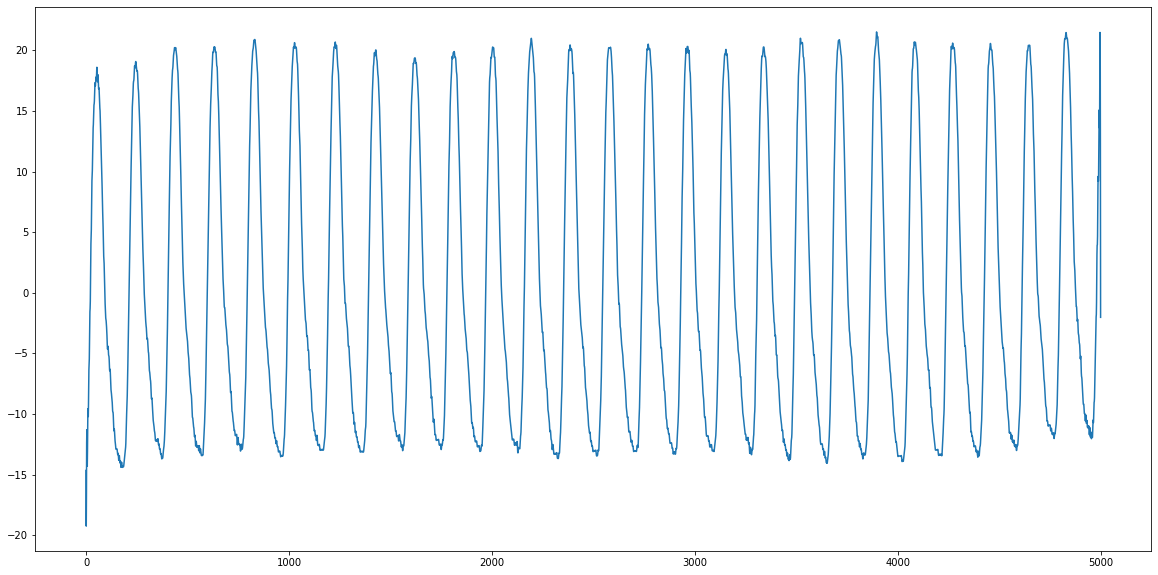

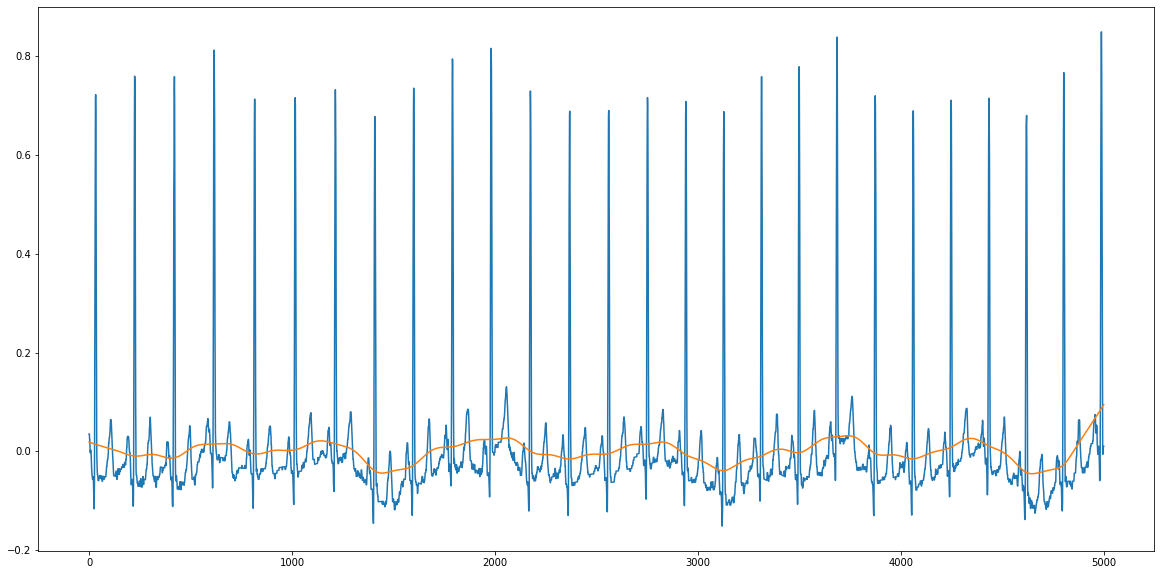

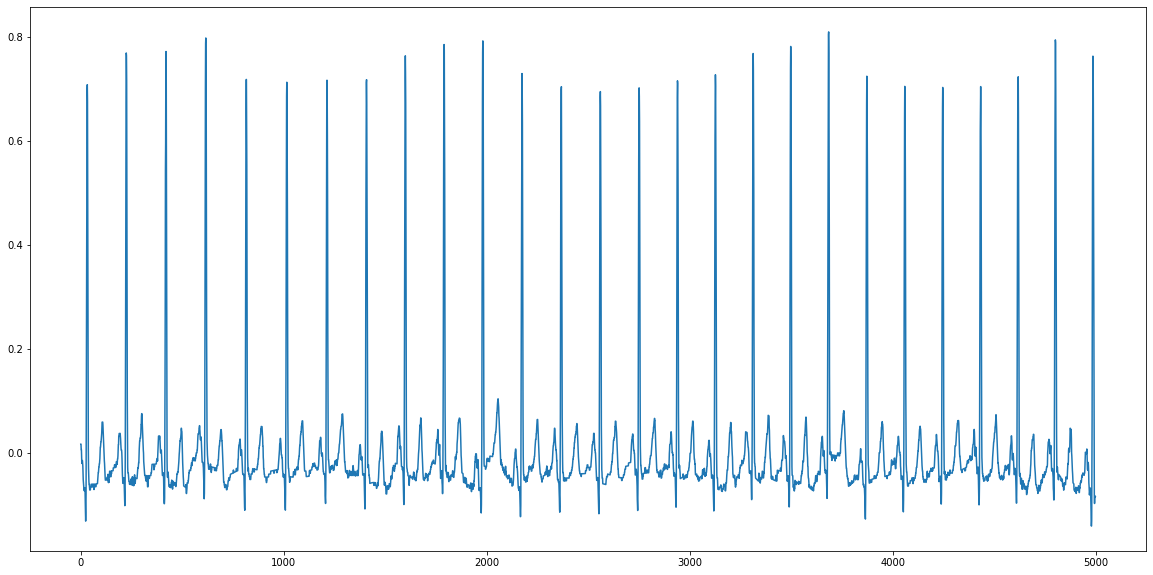

In [96]:
# ECG는 큰 baseline drift(low frequency noise)가 lowess filter(0.2)로는 잘 안지워짐 0.08로 해야 잘 지워짐
# 아래는 preprocess6/input의 x_train_pacu index 100번째에 해당하는 케이스

plt.figure(figsize=(20,10))
plt.plot(x_train_pacu[100,:,0])

plt.figure(figsize=(20,10))
plt.plot(x_train_pacu[100,:,1])
plt.plot(lowess(x_train_pacu[100,:,1], 0.08))

plt.figure(figsize=(20,10))
plt.plot(x_train_pacu[100,:,1]-lowess(x_train_pacu[100,:,1], 0.08))

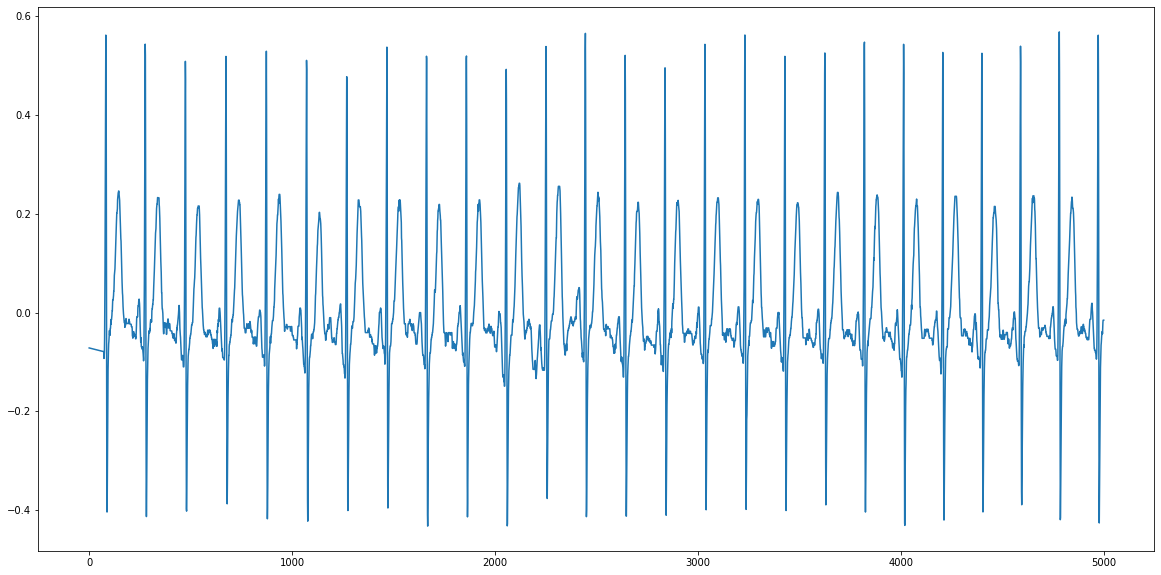

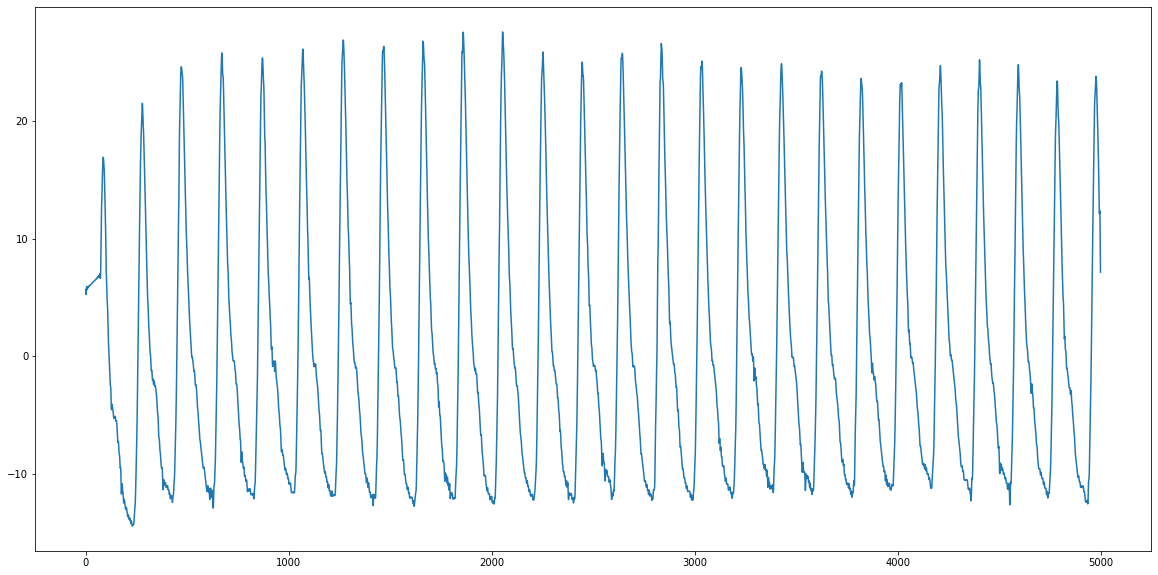

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(ecg_input)

plt.figure(figsize=(20,10))
plt.plot(ppg_input)

In [ ]:
def countLetters(word):
    counter = {}
    for letter in word:
        if letter not in counter:
            counter[letter] = 0
        counter[letter] += 1
    return counter

In [74]:
from collections import Counter


y_count = Counter(y_train_pacu)
y_count

Counter({2.0: 6694,
         5.0: 38195,
         4.0: 20123,
         6.0: 16460,
         7.0: 10789,
         3.0: 17788,
         8.0: 8895,
         9.0: 1341,
         10.0: 227,
         1.0: 85,
         7.5: 12})

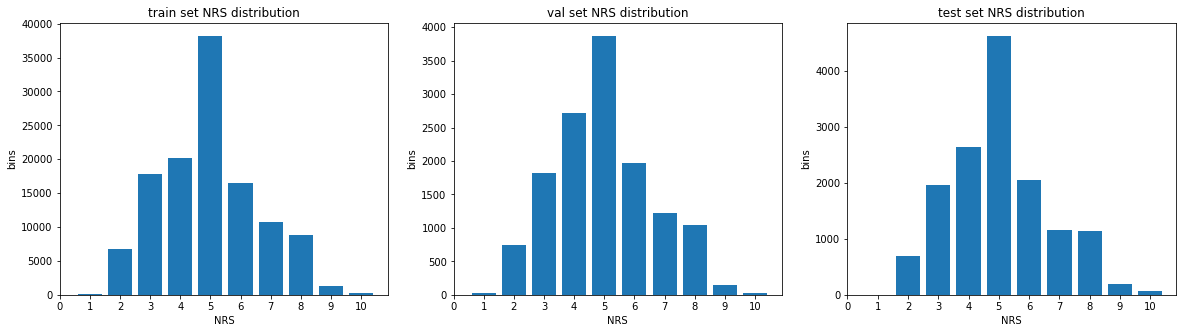

In [88]:
plt.figure(figsize=(20,5))


train_count = Counter(y_train_pacu)
ax1 = plt.subplot(1,3,1)
ax1.bar(train_count.keys(), train_count.values())
ax1.set_xticks(np.arange(11))
ax1.set_xlabel('NRS')
ax1.set_ylabel('bins', rotation=90)
ax1.set_title('train set NRS distribution')


val_count = Counter(y_val_pacu)
ax2 = plt.subplot(1,3,2)
ax2.bar(val_count.keys(), val_count.values())
ax2.set_xticks(np.arange(11))
ax2.set_xlabel('NRS')
ax2.set_ylabel('bins')
ax2.set_title('val set NRS distribution')


test_count = Counter(y_test_pacu)
ax3 = plt.subplot(1,3,3)
ax3.bar(test_count.keys(), test_count.values())
ax3.set_xticks(np.arange(11))
ax3.set_xlabel('NRS')
ax3.set_ylabel('bins')
ax3.set_title('test set NRS distribution')
plt.show()